# COVID-19: Predicting the Spread of Coronavirus

### A Data Science Project by:
### Ronald DeLuca & Lulu Melhem
#### March 10th, 2020

In [1]:
import logging, sys
logging.disable(sys.maxsize)
import warnings
warnings.filterwarnings('ignore',category=FutureWarning)
import pandas as pd
import numpy as np 
import re
import glob
import datetime
import tabulate
import time
from math import sqrt
from IPython.display import HTML, display
from matplotlib import pyplot as plt
import matplotlib.dates as dates
from matplotlib.dates import DateFormatter
#import matplotlib.ticker as mticker
#import mplfinance as mpf
import plotly.graph_objects as go
from sklearn.preprocessing import PolynomialFeatures, MinMaxScaler
from sklearn.model_selection import RandomizedSearchCV, train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, BayesianRidge, ElasticNetCV
from sklearn import svm
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_squared_log_error
from sklearn.metrics import median_absolute_error, r2_score, mean_poisson_deviance
from sklearn.metrics import mean_gamma_deviance, mean_tweedie_deviance, max_error
from sklearn.metrics import explained_variance_score
from statsmodels.tsa.arima_model import ARIMA
from xgboost import XGBRegressor
import keras
from keras.layers import Dense,LSTM,Dropout
from keras import Sequential
from fbprophet import Prophet
from fbprophet.diagnostics import cross_validation
from fbprophet.diagnostics import performance_metrics
from scipy import integrate, optimize
from scipy.integrate import odeint
from scipy.integrate import solve_ivp

Using TensorFlow backend.


In [2]:
t1 = time.time()
# Read all CSVs from data/ folder, preprocess columns and inject Dates from filename
# Concatenate all CSVs into one dataframe, ensuring different formats align correctly.
all_files = glob.glob('./data' + "/*.csv")
li = []
for filename in all_files:
    df = pd.read_csv(filename, index_col=None, header=0)
    df.rename(columns={'Country/Region':'Country'}, inplace=True)
    df.rename(columns={'Country_Region':'Country'}, inplace=True)
    df.rename(columns={'Province/State':'Province_State'}, inplace=True)
    df.rename(columns={'Last Update':'Last_Update'}, inplace=True)
    df.rename(columns={'Admin2':'City'}, inplace=True)
    df.rename(columns={'Lat':'Latitude'}, inplace=True)
    df.rename(columns={'Long_':'Longitude'}, inplace=True)
    dateRe = re.search("([0-9]{2}\-[0-9]{2}\-[0-9]{4})", filename)
    df['Date'] = dateRe.group(1)
    df['Country'].replace({'US':'United States'})
    li.append(df)

covidCompiled = pd.concat(li, axis=0, ignore_index=True)
covidCompiled = covidCompiled[['Date', 'Last_Update', 'Province_State', 'Country', 'Confirmed', 'Deaths', 'Recovered', 
        'Active', 'Latitude', 'Longitude', 'FIPS', 'City', 'Combined_Key']]
values = {'Confirmed': 0, 'Deaths': 0, 'Recovered': 0, 'Active': 0}
covidCompiled.fillna(value=values, inplace=True)
covidCompiled['Last_Update'] =pd.to_datetime(covidCompiled.Last_Update)
covidCompiled['Confirmed'] =pd.to_numeric(covidCompiled.Confirmed)
covidCompiled['Deaths'] =pd.to_numeric(covidCompiled.Deaths)
covidCompiled['Recovered'] =pd.to_numeric(covidCompiled.Recovered)
covidCompiled['Active'] =pd.to_numeric(covidCompiled.Active)
covidCompiled = covidCompiled.sort_values(['Last_Update'], ascending=(True))
covidCompiled = covidCompiled.reset_index(drop=True)
#covidCompiled['Date'] = covidCompiled['Last_Update'].values
covidCompiled['Date'] = pd.to_datetime(covidCompiled['Date']).dt.date
#cols = covidCompiled.columns.tolist()
#cols = cols[-1:] + cols[:-1]
#covidCompiled = covidCompiled[cols]
covidCompiled.to_csv('covidCompiled.csv')
covidCompiled
t2 = time.time()
print('Runtime:', t2-t1)

Runtime: 3.1320481300354004


In [3]:
t3=time.time()
# Use compiled df to fill in missing values in older CSVs through searching
covidFilled = covidCompiled
for row in covidFilled.itertuples():
    if row[13] != row[13]:
        if row[3] != row[3]:
            covidFilled.at[row[0], 'Combined_Key'] = row[4]
        else:
            covidFilled.at[row[0], 'Combined_Key'] = row[3] + ', ' + row[4]
    if row[9] != row[9]:
        found = covidFilled.loc[(covidFilled['Province_State'] == row[3]) & 
                (covidFilled['Latitude'] == covidFilled['Latitude'])]
        if 0 < len(found.values):
            covidFilled.at[row[0], 'Latitude'] = found.values[0][8]
        else:
            newfound = covidFilled.loc[(covidFilled['Country'] == row[4]) & 
                (covidFilled['Latitude'] == covidFilled['Latitude'])]
            if 0 < len(newfound.values):
                covidFilled.at[row[0], 'Latitude'] = newfound.values[0][8]
    if row[10] != row[10]:
        found = covidFilled.loc[(covidFilled['Province_State'] == row[3]) & 
                (covidFilled['Longitude'] == covidFilled['Longitude'])]
        if 0 < len(found.values):
            covidFilled.at[row[0], 'Longitude'] = found.values[0][9]
        else:
            newfound = covidFilled.loc[(covidFilled['Country'] == row[4]) & 
                (covidFilled['Longitude'] == covidFilled['Longitude'])]
            if 0 < len(newfound.values):
                covidFilled.at[row[0], 'Longitude'] = newfound.values[0][9]

for row in covidFilled.itertuples():
    if row[12] != row[12]:
        cityFound = covidFilled.loc[(covidFilled['Latitude'] == row[9]) & 
                (covidFilled['Longitude'] == row[10]) & 
                (covidFilled['City'] == covidFilled['City'])]
        if 0 < len(cityFound.values):
            covidFilled.at[row[0], 'City'] = cityFound.values[0][11]
    if row[11] != row[11]:
        fipsfound = covidFilled.loc[(covidFilled['Latitude'] == row[9]) & 
                (covidFilled['Longitude'] == row[10]) & 
                (covidFilled['FIPS'] == covidFilled['FIPS'])]
        if 0 < len(fipsfound.values):
                covidFilled.at[row[0], 'FIPS'] = fipsfound.values[0][10]
        else:
            newfipsfound = covidFilled.loc[(covidFilled['City'] == row[12]) & 
                (covidFilled['FIPS'] == covidFilled['FIPS'])]
            if 0 < len(newfipsfound.values):
                covidFilled.at[row[0], 'FIPS'] = newfipsfound.values[0][10]

covidFilled.to_csv('covidFilled.csv')
covidFilled
t4 = time.time()
print('Runtime:', t4-t3)

Runtime: 660.1562585830688


In [4]:
# Pre-processed dataframe for all Johns Hopkins CSSE COVID-19 Daily Reports
# https://github.com/CSSEGISandData/COVID-19
covidFilled

,Date,Last_Update,Province_State,Country,Confirmed,Deaths,Recovered,Active,Latitude,Longitude,FIPS,City,Combined_Key
0,2020-01-22,2020-01-22 17:00:00,Xinjiang,Mainland China,0.0,0.0,0.0,0.0,41.112900,85.240100,NaN,NaN,"Xinjiang, Mainland China"
1,2020-01-22,2020-01-22 17:00:00,Inner Mongolia,Mainland China,0.0,0.0,0.0,0.0,44.093500,113.944800,NaN,NaN,"Inner Mongolia, Mainland China"
2,2020-01-22,2020-01-22 17:00:00,Anhui,Mainland China,1.0,0.0,0.0,0.0,31.825700,117.226400,NaN,NaN,"Anhui, Mainland China"
3,2020-01-22,2020-01-22 17:00:00,Beijing,Mainland China,14.0,0.0,0.0,0.0,40.182400,116.414200,NaN,NaN,"Beijing, Mainland China"
4,2020-01-22,2020-01-22 17:00:00,Chongqing,Mainland China,6.0,0.0,0.0,0.0,30.057200,107.874000,NaN,NaN,"Chongqing, Mainland China"
...,...,...,...,...,...,...,...,...,...,...,...,...,...
123693,2020-04-28,2020-04-29 02:32:29,NaN,Greece,2566.0,138.0,577.0,1851.0,39.074200,21.824300,NaN,NaN,Greece
123694,2020-04-28,2020-04-29 02:32:29,NaN,Ghana,1671.0,16.0,188.0,1467.0,7.946500,-1.023200,NaN,NaN,Ghana
123695,2020-04-28,2020-04-29 02:32:29,NaN,Germany,159912.0,6314.0,117400.0,36198.0,51.165691,10.451526,NaN,NaN,Germany
123696,2020-04-28,2020-04-29 02:32:29,NaN,Guyana,74.0,8.0,15.0,51.0,4.860416,-58.930180,NaN,NaN,Guyana


In [5]:
t5=time.time()
# Johns Hopkins CSVs pulled here to verify numbers against.
#confirmedUrlTs = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Confirmed.csv'
confirmedUrlTs = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv'
confirmedUrlUSTs = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_US.csv'
#deathsUrlTs = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Deaths.csv'
deathsUrlTs = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv'
deathsUrlUSTs = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_US.csv'
#recoveredUrlTs = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Recovered.csv'
recoveredUrlTs = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv'
#covidCompiled = './covid_19_data.csv'
openLineCovid = './COVID19_open_line_list.csv'
df_confirmed = pd.read_csv(confirmedUrlTs)
df_confirmedUS = pd.read_csv(confirmedUrlUSTs)
df_deaths = pd.read_csv(deathsUrlTs)
df_deathsUS = pd.read_csv(deathsUrlUSTs)
df_recovered = pd.read_csv(recoveredUrlTs)
df_kOLine = pd.read_csv(openLineCovid)
df_kOLine = df_kOLine.dropna(how='all')
df_kOLine = df_kOLine.dropna(how='all', axis=1)
#df_compiled = pd.read_csv(covidCompiled, parse_dates=['Last Update'])

df_confirmed.rename(columns={'Country/Region':'Country'}, inplace=True)
df_recovered.rename(columns={'Country/Region':'Country'}, inplace=True)
df_deaths.rename(columns={'Country/Region':'Country'}, inplace=True)
#df_compiled.rename(columns={'ObservationDate':'Date', 'Country/Region':'Country'}, inplace=True)
#df_confirmed.head()
t6 = time.time()
print('Runtime:', t6-t5)

Runtime: 1.0312347412109375


In [6]:
## Kaggle COVID19 Open Line List CSV
df_kOLine

,ID,age,sex,city,province,country,wuhan(0)_not_wuhan(1),latitude,longitude,geo_resolution,...,outcome,date_death_or_discharge,notes_for_discussion,location,admin3,admin2,admin1,country_new,admin_id,data_moderator_initials
0,1.0,30,male,"Chaohu City, Hefei City",Anhui,China,1.0,31.646960,117.716600,admin3,...,NaN,NaN,NaN,NaN,Chaohu City,Hefei City,Anhui,China,340181,NaN
1,2.0,47,male,"Baohe District, Hefei City",Anhui,China,1.0,31.778630,117.331900,admin3,...,NaN,NaN,NaN,NaN,Baohe District,Hefei City,Anhui,China,340111,NaN
2,3.0,49,male,"High-Tech Zone, Hefei City",Anhui,China,1.0,31.828313,117.224844,point,...,NaN,NaN,NaN,High-Tech Zone,Shushan District,Hefei City,Anhui,China,340104,NaN
3,4.0,47,female,"High-Tech Zone, Hefei City",Anhui,China,1.0,31.828313,117.224844,point,...,NaN,NaN,NaN,High-Tech Zone,Shushan District,Hefei City,Anhui,China,340104,NaN
4,5.0,50,female,"Feidong County, Hefei City",Anhui,China,1.0,32.001230,117.568100,admin3,...,NaN,NaN,NaN,NaN,Feidong County,Hefei City,Anhui,China,340122,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13169,13475.0,60-69,male,Nagoya City,Aichi Prefecture,Japan,1.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13170,13476.0,40-49,female,NaN,Osaka,Japan,1.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13171,13477.0,0-10,female,NaN,Osaka,Japan,1.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13172,13478.0,NaN,female,Amsterdam,NaN,Netherlands,1.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
# Population data set 
# Source of dataset: https://www.kaggle.com/dgrechka/covid19-global-forecasting-locations-population 

population_data=pd.read_csv('./locations_population.csv')
population_data.rename(columns={'Country.Region':'Country'}, inplace=True)
population_data.rename(columns={'Province.State':'State/Province'}, inplace=True)

US_population = population_data.loc[population_data['Country'] == 'US'].sum()['Population']
FL_population = population_data.loc[population_data['State/Province'] == 'Florida'].sum()['Population']
world_population = population_data.sum()['Population']

In [8]:
t7=time.time()
count = 0
upper = 1
new_df = pd.DataFrame()
for row in df_confirmed.itertuples():
    count += 1
    upper += 1
    if upper < len(df_confirmed.index):
        confir = df_confirmed[count:upper].T
        confir.insert(0, "ProvinceState", confir.values[0][0])
        confir.insert(1, "Country", confir.values[1][1])
        confir.insert(2, "Lat", confir.values[2][2])
        confir.insert(3, "Long", confir.values[3][3])
        confir.columns.values[4] = 'Confirmed'
        confirm = confir[4:]

        deat = df_deaths[count:upper].T
        death = deat[4:]
        #recov = df_recovered[count:upper].T
        #recove = recov[4:]

        compl = pd.concat([confirm, death], axis=1)
        #compl = pd.concat([confirm, death, recove], axis=1)
        compl.columns.values[5] = 'Deaths'
        #compl.columns.values[6] = 'Recovered'
        new_df = pd.concat([new_df, compl])
    elif upper == len(df_confirmed.index):
        confir = df_confirmed[-1:].T
        confir.insert(0, "ProvinceState", confir.values[0][0])
        confir.insert(1, "Country", confir.values[1][1])
        confir.insert(2, "Lat", confir.values[2][2])
        confir.insert(3, "Long", confir.values[3][3])
        confir.columns.values[4] = 'Confirmed'
        confirm = confir[4:]

        deat = df_deaths[-1:].T
        death = deat[4:]
        #recov = df_recovered[-1:].T
        #recove = recov[4:]

        compl = pd.concat([confirm, death], axis=1)
        #compl = pd.concat([confirm, death, recove], axis=1)
        compl.columns.values[5] = 'Deaths'
        #compl.columns.values[6] = 'Recovered'
        new_df = pd.concat([new_df, compl])
    else:
        confir = df_confirmed[:1].T
        confir.insert(0, "ProvinceState", confir.values[0][0])
        confir.insert(1, "Country", confir.values[1][1])
        confir.insert(2, "Lat", confir.values[2][2])
        confir.insert(3, "Long", confir.values[3][3])
        confir.columns.values[4] = 'Confirmed'
        confirm = confir[4:]

        deat = df_deaths[:1].T
        death = deat[4:]
        #recov = df_recovered[:1].T
        #recove = recov[4:]

        compl = pd.concat([confirm, death], axis=1)
        #compl = pd.concat([confirm, death, recove], axis=1)
        compl.columns.values[5] = 'Deaths'
        #compl.columns.values[6] = 'Recovered'
        new_df = pd.concat([new_df, compl])
        

print (count)
new_df.sort_index()
new_df['Date'] = new_df.index
cols = new_df.columns.tolist()
cols = cols[-1:] + cols[:-1]
new_df = new_df[cols]
new_df['Date'] =pd.to_datetime(new_df.Date)
new_df['Confirmed'] =pd.to_numeric(new_df.Confirmed)
new_df['Deaths'] =pd.to_numeric(new_df.Deaths)
#new_df['Recovered'] =pd.to_numeric(new_df.Recovered)
new_df = new_df.sort_values(['Date', 'Country'], ascending=(True, True))
new_df = new_df.reset_index(drop=True)
covidFull = new_df
covidFull.to_csv('basicCovid.csv')
#covidFull
t8 = time.time()
print('Runtime:', t8-t7)

264
Runtime: 2.865917205810547


In [9]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [10]:
# Prepare variables for ranges, dates used in plots and predictions
t9=time.time()
datesGroup = covidFilled.groupby('Date').sum()[['Confirmed', 'Deaths', 'Recovered']].reset_index()
datesGroup.to_csv('datesGroup.csv')
datesGroupUS = covidFilled.loc[covidFilled['Country'] == 'US'].groupby('Date').sum()[['Confirmed', 'Deaths', 'Recovered']].reset_index()

days_range = np.array([i for i in range(len(datesGroup))]).reshape(-1, 1)
future_range = np.array([i for i in range(len(datesGroup)+10)]).reshape(-1, 1)
adjusted_dates = future_range[:-10]
start_date = datetime.datetime.strptime('2020-01-22', '%Y-%m-%d')
start_short = datetime.datetime.strptime('01-22', '%m-%d')
future_range_dates = []
future_range_dates_short = []
for i in range(len(future_range)):
    future_range_dates.append((start_date + datetime.timedelta(days=i)).strftime('%Y-%m-%d'))
    future_range_dates_short.append((start_short + datetime.timedelta(days=i)).strftime('%m-%d'))
world_confirmed = datesGroup['Confirmed'].to_numpy()
t10 = time.time()
print('Runtime:', t10-t9)

Runtime: 0.1128997802734375


In [11]:
# Split the world_confirmed df into testing and training sets
X_train_world_confirmed, X_test_world_confirmed, y_train_world_confirmed, y_test_world_confirmed = \
train_test_split(days_range, world_confirmed, test_size=0.25, shuffle=False)

## Linear Regression

In [12]:
## Worldwide Linear Regression
t11=time.time()
linear_reg_model = LinearRegression(normalize=True, fit_intercept=False)
linear_reg_model.fit(X_train_world_confirmed, y_train_world_confirmed)
test_linear_world_conf_pred = linear_reg_model.predict(X_test_world_confirmed)
linear_world_conf_pred = linear_reg_model.predict(future_range)

mAE_linear_world_conf = mean_absolute_error(y_test_world_confirmed, test_linear_world_conf_pred)
mSE_linear_world_conf = mean_squared_error(y_test_world_confirmed, test_linear_world_conf_pred)
mSLE_linear_world_conf = mean_squared_log_error(y_test_world_confirmed, test_linear_world_conf_pred)
rMSE_linear_world_conf = sqrt(mean_squared_error(y_test_world_confirmed, test_linear_world_conf_pred))
mAbE_linear_world_conf = median_absolute_error(y_test_world_confirmed, test_linear_world_conf_pred)
mAPE_linear_world_conf = mean_absolute_percentage_error(y_test_world_confirmed, test_linear_world_conf_pred)
r2_linear_world_conf = r2_score(y_test_world_confirmed, test_linear_world_conf_pred)
mPD_linear_world_conf = mean_poisson_deviance(y_test_world_confirmed, test_linear_world_conf_pred)
mGD_linear_world_conf = mean_gamma_deviance(y_test_world_confirmed, test_linear_world_conf_pred)
mTD_linear_world_conf = mean_tweedie_deviance(y_test_world_confirmed, test_linear_world_conf_pred)
mE_linear_world_conf = max_error(y_test_world_confirmed, test_linear_world_conf_pred)
mEVS_linear_world_conf = explained_variance_score(y_test_world_confirmed, test_linear_world_conf_pred)

print('Linear Regression on Worldwide Confirmed Cases: ')

table = [[mAE_linear_world_conf,mSE_linear_world_conf,mSLE_linear_world_conf,
          rMSE_linear_world_conf,mAbE_linear_world_conf,mAPE_linear_world_conf,
          r2_linear_world_conf,mPD_linear_world_conf,mGD_linear_world_conf,
          mTD_linear_world_conf,mE_linear_world_conf,mEVS_linear_world_conf]]
headName = ['Mean Absolute Err', 'Mean Squared Err', 'Mean Squared Log Err', 'Root Mean Squared Err', 
            'Median Absolute Err', 'Mean Absolute Percentage Err', 'R2 Score', 
            'Mean Poisson Deviance', 'Mean Gamma Deviance', 'Mean Tweedie Deviance', 
           'Max Error', 'Explained Variance Score']
display(HTML(tabulate.tabulate(table, tablefmt='html', headers=headName)))
t12 = time.time()
print('Runtime:', t12-t11)

Linear Regression on Worldwide Confirmed Cases: 


Mean Absolute Err,Mean Squared Err,Mean Squared Log Err,Root Mean Squared Err,Median Absolute Err,Mean Absolute Percentage Err,R2 Score,Mean Poisson Deviance,Mean Gamma Deviance,Mean Tweedie Deviance,Max Error,Explained Variance Score
1.62167e+06,2.91534e+12,1.88744,1.70744e+06,1.61792e+06,73.7902,-7.67552,2.8468e+06,3.21926,2.91534e+12,2.50618e+06,0.150362


Runtime: 0.008931159973144531


In [13]:
t13=time.time()
linear_world_conf_pred = linear_world_conf_pred.reshape(1,-1)[0]
print('Linear Regression Worldwide Confirmed Cases Future Predictions: ')
t14 = time.time()
print('Runtime:', t14-t13)
set(zip(future_range_dates[-10:], np.round(linear_world_conf_pred[-10:])))

Linear Regression Worldwide Confirmed Cases Future Predictions: 
Runtime: 0.0001881122589111328


{('2020-04-29', 616506.0),
 ('2020-04-30', 622797.0),
 ('2020-05-01', 629088.0),
 ('2020-05-02', 635379.0),
 ('2020-05-03', 641670.0),
 ('2020-05-04', 647961.0),
 ('2020-05-05', 654252.0),
 ('2020-05-06', 660542.0),
 ('2020-05-07', 666833.0),
 ('2020-05-08', 673124.0)}

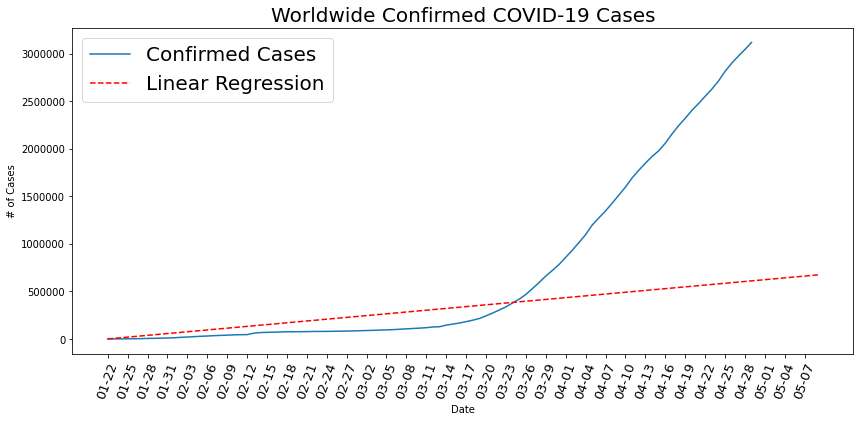

Runtime: 0.2897062301635742


In [14]:
t15=time.time()
plt.figure(figsize=(14, 6))
plt.plot(adjusted_dates, world_confirmed)
plt.plot(future_range_dates_short, linear_world_conf_pred, linestyle='dashed', color='red')
plt.title('Worldwide Confirmed COVID-19 Cases', size=20)
plt.xlabel('Date', size=10)
plt.ylabel('# of Cases', size=10)
plt.legend(['Confirmed Cases', 'Linear Regression'], prop={'size': 20})
plt.xticks(np.arange(len(future_range_dates), step=3),size=13, rotation=70)
plt.yticks(size=10)
ax = plt.gca()
ax.yaxis.get_major_formatter().set_scientific(False)
plt.show()
t16 = time.time()
print('Runtime:', t16-t15)

## Polynomial Regression

In [15]:
## Worldwide Polynomial Regression
t17=time.time()
poly_features = PolynomialFeatures(degree=5)
poly_X_train_world_confirmed = poly_features.fit_transform(X_train_world_confirmed)
poly_X_test_world_confirmed = poly_features.fit_transform(X_test_world_confirmed)
poly_future_world_forecast = poly_features.fit_transform(future_range)

poly_reg_model = LinearRegression(normalize=True, fit_intercept=False)
poly_reg_model.fit(poly_X_train_world_confirmed, y_train_world_confirmed)
test_poly_world_conf_pred = poly_reg_model.predict(poly_X_test_world_confirmed)
poly_world_conf_pred = poly_reg_model.predict(poly_future_world_forecast)

mAE_poly_world_conf = mean_absolute_error(y_test_world_confirmed, test_poly_world_conf_pred)
mSE_poly_world_conf = mean_squared_error(y_test_world_confirmed, test_poly_world_conf_pred)
mSLE_poly_world_conf = mean_squared_log_error(y_test_world_confirmed, test_poly_world_conf_pred)
rMSE_poly_world_conf = sqrt(mean_squared_error(y_test_world_confirmed, test_poly_world_conf_pred))
mAbE_poly_world_conf = median_absolute_error(y_test_world_confirmed, test_poly_world_conf_pred)
mAPE_poly_world_conf = mean_absolute_percentage_error(y_test_world_confirmed, test_poly_world_conf_pred)
r2_poly_world_conf = r2_score(y_test_world_confirmed, test_poly_world_conf_pred)
mPD_poly_world_conf = mean_poisson_deviance(y_test_world_confirmed, test_poly_world_conf_pred)
mGD_poly_world_conf = mean_gamma_deviance(y_test_world_confirmed, test_poly_world_conf_pred)
mTD_poly_world_conf = mean_tweedie_deviance(y_test_world_confirmed, test_poly_world_conf_pred)
mE_poly_world_conf = max_error(y_test_world_confirmed, test_poly_world_conf_pred)
mEVS_poly_world_conf = explained_variance_score(y_test_world_confirmed, test_poly_world_conf_pred)

print('Polynomial Regression on Worldwide Confirmed Cases: ')
table = [[mAE_poly_world_conf,mSE_poly_world_conf,mSLE_poly_world_conf,
          rMSE_poly_world_conf,mAbE_poly_world_conf,mAPE_poly_world_conf,
          r2_poly_world_conf,mPD_poly_world_conf,mGD_poly_world_conf,
          mTD_poly_world_conf,mE_poly_world_conf,mEVS_poly_world_conf]]
headName = ['Mean Absolute Err', 'Mean Squared Err', 'Mean Squared Log Err', 'Root Mean Squared Err', 
            'Median Absolute Err', 'Mean Absolute Percentage Err', 'R2 Score', 
            'Mean Poisson Deviance', 'Mean Gamma Deviance', 'Mean Tweedie Deviance', 
           'Max Error', 'Explained Variance Score']
display(HTML(tabulate.tabulate(table, tablefmt='html', headers=headName)))
t18=time.time()
print('Runtime:', t18-t17)

Polynomial Regression on Worldwide Confirmed Cases: 


Mean Absolute Err,Mean Squared Err,Mean Squared Log Err,Root Mean Squared Err,Median Absolute Err,Mean Absolute Percentage Err,R2 Score,Mean Poisson Deviance,Mean Gamma Deviance,Mean Tweedie Deviance,Max Error,Explained Variance Score
1.36139e+06,3.21752e+12,0.216491,1.79374e+06,1.02899e+06,53.2412,-8.57475,728165,0.178369,3.21752e+12,3.89264e+06,-3.05941


Runtime: 0.008797645568847656


In [16]:
t19=time.time()
poly_world_conf_pred = poly_world_conf_pred.reshape(1,-1)[0]
print('Polynomial Regression Worldwide Confirmed Cases Future Predictions: ')
t20 = time.time()
print('Runtime:', t20-t19)
set(zip(future_range_dates[-10:], np.round(poly_world_conf_pred[-10:])))

Polynomial Regression Worldwide Confirmed Cases Future Predictions: 
Runtime: 0.0002124309539794922


{('2020-04-29', 7441225.0),
 ('2020-04-30', 7893675.0),
 ('2020-05-01', 8367039.0),
 ('2020-05-02', 8861985.0),
 ('2020-05-03', 9379189.0),
 ('2020-05-04', 9919345.0),
 ('2020-05-05', 10483154.0),
 ('2020-05-06', 11071333.0),
 ('2020-05-07', 11684612.0),
 ('2020-05-08', 12323731.0)}

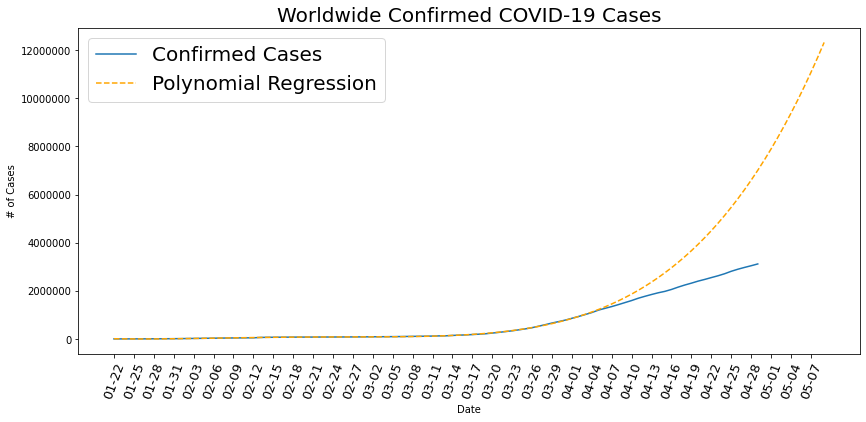

Runtime: 0.30641937255859375


In [17]:
t21=time.time()
plt.figure(figsize=(14, 6))
plt.plot(adjusted_dates, world_confirmed)
plt.plot(future_range_dates_short, poly_world_conf_pred, linestyle='dashed', color='orange')
plt.title('Worldwide Confirmed COVID-19 Cases', size=20)
plt.xlabel('Date', size=10)
plt.ylabel('# of Cases', size=10)
plt.legend(['Confirmed Cases', 'Polynomial Regression'], prop={'size': 20})
plt.xticks(np.arange(len(future_range_dates), step=3),size=13, rotation=70)
plt.yticks(size=10)
ax = plt.gca()
ax.yaxis.get_major_formatter().set_scientific(False)
plt.show()
t22 = time.time()
print('Runtime:', t22-t21)

## SVM

In [18]:
# Worldwide SVM Predictions
t23=time.time()
svm_reg_model = svm.SVR(shrinking=True, kernel='poly',gamma=0.01, epsilon=1,degree=4, C=0.1)
svm_reg_model.fit(X_train_world_confirmed, y_train_world_confirmed)
test_svm_world_conf_pred = svm_reg_model.predict(X_test_world_confirmed)
svm_world_conf_pred = svm_reg_model.predict(future_range)

mAE_svm_world_conf = mean_absolute_error(y_test_world_confirmed, test_svm_world_conf_pred)
mSE_svm_world_conf = mean_squared_error(y_test_world_confirmed, test_svm_world_conf_pred)
mSLE_svm_world_conf = mean_squared_log_error(y_test_world_confirmed, test_svm_world_conf_pred)
rMSE_svm_world_conf = sqrt(mean_squared_error(y_test_world_confirmed, test_svm_world_conf_pred))
mAbE_svm_world_conf = median_absolute_error(y_test_world_confirmed, test_svm_world_conf_pred)
mAPE_svm_world_conf = mean_absolute_percentage_error(y_test_world_confirmed, test_svm_world_conf_pred)
r2_svm_world_conf = r2_score(y_test_world_confirmed, test_svm_world_conf_pred)
mPD_svm_world_conf = mean_poisson_deviance(y_test_world_confirmed, test_svm_world_conf_pred)
mGD_svm_world_conf = mean_gamma_deviance(y_test_world_confirmed, test_svm_world_conf_pred)
mTD_svm_world_conf = mean_tweedie_deviance(y_test_world_confirmed, test_svm_world_conf_pred)
mE_svm_world_conf = max_error(y_test_world_confirmed, test_svm_world_conf_pred)
mEVS_svm_world_conf = explained_variance_score(y_test_world_confirmed, test_svm_world_conf_pred)

print('SVM on Worldwide Confirmed Cases: ')
table = [[mAE_svm_world_conf,mSE_svm_world_conf,mSLE_svm_world_conf,
          rMSE_svm_world_conf,mAbE_svm_world_conf,mAPE_svm_world_conf,
          r2_svm_world_conf,mPD_svm_world_conf,mGD_svm_world_conf,
          mTD_svm_world_conf,mE_svm_world_conf,mEVS_svm_world_conf]]
headName = ['Mean Absolute Err', 'Mean Squared Err', 'Mean Squared Log Err', 'Root Mean Squared Err', 
            'Median Absolute Err', 'Mean Absolute Percentage Err', 'R2 Score', 
            'Mean Poisson Deviance', 'Mean Gamma Deviance', 'Mean Tweedie Deviance', 
           'Max Error', 'Explained Variance Score']
display(HTML(tabulate.tabulate(table, tablefmt='html', headers=headName)))
t24 = time.time()
print('Runtime:', t24-t23)

SVM on Worldwide Confirmed Cases: 


Mean Absolute Err,Mean Squared Err,Mean Squared Log Err,Root Mean Squared Err,Median Absolute Err,Mean Absolute Percentage Err,R2 Score,Mean Poisson Deviance,Mean Gamma Deviance,Mean Tweedie Deviance,Max Error,Explained Variance Score
587274,3.52854e+11,0.115526,594015,611365,28.3062,-0.0500302,205045,0.130487,3.52854e+11,675454,0.976303


Runtime: 0.02437734603881836


In [19]:
t25=time.time()
svm_world_conf_pred = svm_world_conf_pred.reshape(1,-1)[0]
print('SVM Worldwide Confirmed Cases Future Predictions: ')
t26 = time.time()
print('Runtime:', t26-t25)
set(zip(future_range_dates[-10:], np.round(svm_world_conf_pred[-10:])))

SVM Worldwide Confirmed Cases Future Predictions: 
Runtime: 0.00015497207641601562


{('2020-04-29', 2644199.0),
 ('2020-04-30', 2752989.0),
 ('2020-05-01', 2865126.0),
 ('2020-05-02', 2980678.0),
 ('2020-05-03', 3099714.0),
 ('2020-05-04', 3222303.0),
 ('2020-05-05', 3348515.0),
 ('2020-05-06', 3478421.0),
 ('2020-05-07', 3612092.0),
 ('2020-05-08', 3749600.0)}

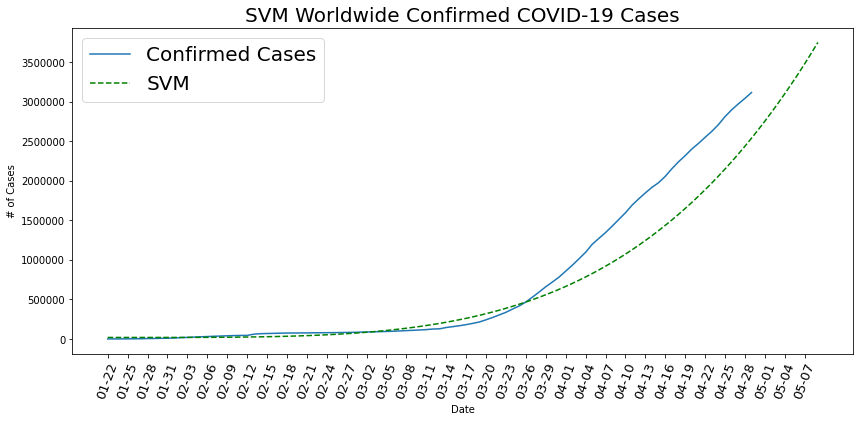

Runtime: 0.3047323226928711


In [20]:
t27=time.time()
plt.figure(figsize=(14, 6))
plt.plot(adjusted_dates, world_confirmed)
plt.plot(future_range_dates_short, svm_world_conf_pred, linestyle='dashed', color='green')
plt.title('SVM Worldwide Confirmed COVID-19 Cases', size=20)
plt.xlabel('Date', size=10)
plt.ylabel('# of Cases', size=10)
plt.legend(['Confirmed Cases', 'SVM'], prop={'size': 20})
plt.xticks(np.arange(len(future_range_dates), step=3),size=13, rotation=70)
plt.yticks(size=10)
ax = plt.gca()
ax.yaxis.get_major_formatter().set_scientific(False)
plt.show()
t28 = time.time()
print('Runtime:', t28-t27)

## XGBoost

In [21]:
t29=time.time()
xgb_model = XGBRegressor(booster='gblinear', lamba=20, alpha=0.2)
xgb_model.fit(poly_X_train_world_confirmed, y_train_world_confirmed)
#xgb_model.fit(X_train_world_confirmed, y_train_world_confirmed,
#        eval_set=[(X_train_world_confirmed, y_train_world_confirmed), 
#                  (X_test_world_confirmed, y_test_world_confirmed)],
#        early_stopping_rounds=50,
#       verbose=False)
test_xgb_world_conf_pred = xgb_model.predict(poly_X_test_world_confirmed)
xgb_world_conf_pred = xgb_model.predict(poly_future_world_forecast)

mAE_xgb_world_conf = mean_absolute_error(y_test_world_confirmed, test_xgb_world_conf_pred)
mSE_xgb_world_conf = mean_squared_error(y_test_world_confirmed, test_xgb_world_conf_pred)
mSLE_xgb_world_conf = mean_squared_log_error(y_test_world_confirmed, test_xgb_world_conf_pred)
rMSE_xgb_world_conf = sqrt(mean_squared_error(y_test_world_confirmed, test_xgb_world_conf_pred))
mAbE_xgb_world_conf = median_absolute_error(y_test_world_confirmed, test_xgb_world_conf_pred)
mAPE_xgb_world_conf = mean_absolute_percentage_error(y_test_world_confirmed, test_xgb_world_conf_pred)
r2_xgb_world_conf = r2_score(y_test_world_confirmed, test_xgb_world_conf_pred)
mPD_xgb_world_conf = mean_poisson_deviance(y_test_world_confirmed, test_xgb_world_conf_pred)
mGD_xgb_world_conf = mean_gamma_deviance(y_test_world_confirmed, test_xgb_world_conf_pred)
mTD_xgb_world_conf = mean_tweedie_deviance(y_test_world_confirmed, test_xgb_world_conf_pred)
mE_xgb_world_conf = max_error(y_test_world_confirmed, test_xgb_world_conf_pred)
mEVS_xgb_world_conf = explained_variance_score(y_test_world_confirmed, test_xgb_world_conf_pred)

print('XGBoost on Worldwide Confirmed Cases: ')
table = [[mAE_xgb_world_conf,mSE_xgb_world_conf,mSLE_xgb_world_conf,
          rMSE_xgb_world_conf,mAbE_xgb_world_conf,mAPE_xgb_world_conf,
          r2_xgb_world_conf,mPD_xgb_world_conf,mGD_xgb_world_conf,
          mTD_xgb_world_conf,mE_xgb_world_conf,mEVS_xgb_world_conf]]
headName = ['Mean Absolute Err', 'Mean Squared Err', 'Mean Squared Log Err', 'Root Mean Squared Err', 
            'Median Absolute Err', 'Mean Absolute Percentage Err', 'R2 Score', 
            'Mean Poisson Deviance', 'Mean Gamma Deviance', 'Mean Tweedie Deviance', 
           'Max Error', 'Explained Variance Score']
display(HTML(tabulate.tabulate(table, tablefmt='html', headers=headName)))
t30=time.time()
print('Runtime:', t30-t29)

XGBoost on Worldwide Confirmed Cases: 


Mean Absolute Err,Mean Squared Err,Mean Squared Log Err,Root Mean Squared Err,Median Absolute Err,Mean Absolute Percentage Err,R2 Score,Mean Poisson Deviance,Mean Gamma Deviance,Mean Tweedie Deviance,Max Error,Explained Variance Score
358908,2.605e+11,0.0256676,510392,132710,14.1664,0.224797,76700.3,0.0238311,2.605e+11,1.25526e+06,0.469686


Runtime: 0.025949478149414062


In [22]:
t31=time.time()
xgb_world_conf_pred = xgb_world_conf_pred.reshape(1,-1)[0]
print('XGBoost Worldwide Confirmed Cases Future Predictions: ')
t32=time.time()
print('Runtime:', t32-t31)
set(zip(future_range_dates[-10:], np.round(xgb_world_conf_pred[-10:])))

XGBoost Worldwide Confirmed Cases Future Predictions: 
Runtime: 0.0006225109100341797


{('2020-04-29', 4596890.0),
 ('2020-04-30', 4831178.0),
 ('2020-05-01', 5074794.0),
 ('2020-05-02', 5328010.0),
 ('2020-05-03', 5591101.0),
 ('2020-05-04', 5864350.0),
 ('2020-05-05', 6148046.0),
 ('2020-05-06', 6442480.0),
 ('2020-05-07', 6747952.0),
 ('2020-05-08', 7064764.0)}

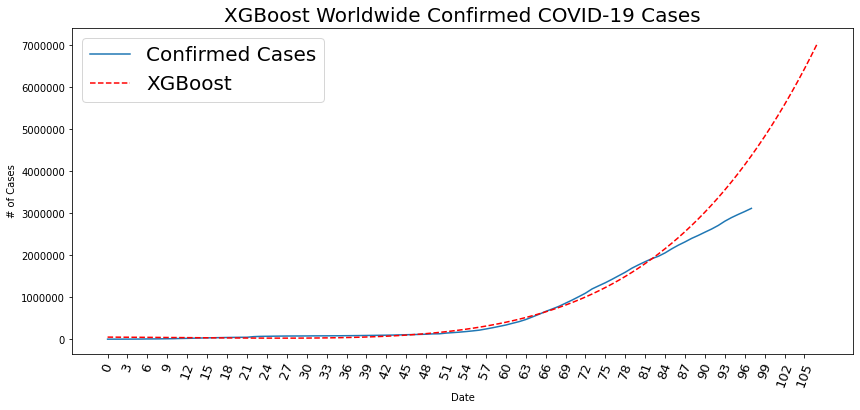

Runtime: 0.2772495746612549


In [23]:
t33=time.time()
plt.figure(figsize=(14, 6))
plt.plot(adjusted_dates, world_confirmed)
plt.plot(future_range, xgb_world_conf_pred, linestyle='dashed', color='red')
plt.title('XGBoost Worldwide Confirmed COVID-19 Cases', size=20)
plt.xlabel('Date', size=10)
plt.ylabel('# of Cases', size=10)
plt.legend(['Confirmed Cases', 'XGBoost'], prop={'size': 20})
plt.xticks(np.arange(len(future_range_dates), step=3),size=13, rotation=70)
plt.yticks(size=10)
ax = plt.gca()
ax.yaxis.get_major_formatter().set_scientific(False)
plt.show()
t34=time.time()
print('Runtime:', t34-t33)

## ARIMA

In [24]:
t35=time.time()
arma_reg_model = ARIMA(world_confirmed, order=(1, 2, 0))
#neighbors_classifier.fit(poly_X_train_world_confirmed, y_train_world_confirmed)
#arma_reg_model.fit(X_train_world_confirmed, y_train_world_confirmed)
arma_model_fit = arma_reg_model.fit(disp=False)
test_arma_world_conf_pred = arma_reg_model.predict(X_test_world_confirmed)
print(arma_model_fit.summary())
residuals = pd.DataFrame(arma_model_fit.resid)
#residuals.plot()
arma_model_fit
#pyplot.show()
#yhat = arma_model_fit.predict(X_test_world_confirmed, future_range, typ='levels')
#print(yhat)
#test_arma_world_conf_pred = arma_reg_model.predict(X_test_world_confirmed)
#arma_world_conf_pred = arma_reg_model.predict(future_range)
t36=time.time()
print('Runtime:', t36-t35)

                             ARIMA Model Results                              
Dep. Variable:                   D2.y   No. Observations:                   96
Model:                 ARIMA(1, 2, 0)   Log Likelihood                -988.106
Method:                       css-mle   S.D. of innovations           7141.844
Date:                Wed, 29 Apr 2020   AIC                           1982.213
Time:                        16:34:27   BIC                           1989.906
Sample:                             2   HQIC                          1985.323
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        776.4167    637.299      1.218      0.223    -472.666    2025.499
ar.L1.D2.y    -0.1453      0.101     -1.445      0.148      -0.342       0.052
                                    Roots           

In [25]:
#arma_model_fit.forecast()
#test_arma_world_conf_pred

## K Nearest Neighbors

In [26]:
t37=time.time()
neighbors_reg_model = KNeighborsRegressor(n_neighbors=4, weights='uniform', algorithm='auto',
                            leaf_size=30, p=2, metric='minkowski', n_jobs=3)
#neighbors_classifier.fit(poly_X_train_world_confirmed, y_train_world_confirmed)
neighbors_reg_model.fit(X_train_world_confirmed, y_train_world_confirmed)
test_neighbors_world_conf_pred = neighbors_reg_model.predict(X_test_world_confirmed)
neighbors_world_conf_pred = neighbors_reg_model.predict(future_range)

mAE_neighbors_world_conf = mean_absolute_error(y_test_world_confirmed, test_neighbors_world_conf_pred)
mSE_neighbors_world_conf = mean_squared_error(y_test_world_confirmed, test_neighbors_world_conf_pred)
mSLE_neighbors_world_conf = mean_squared_log_error(y_test_world_confirmed, test_neighbors_world_conf_pred)
rMSE_neighbors_world_conf = sqrt(mean_squared_error(y_test_world_confirmed, test_neighbors_world_conf_pred))
mAbE_neighbors_world_conf = median_absolute_error(y_test_world_confirmed, test_neighbors_world_conf_pred)
mAPE_neighbors_world_conf = mean_absolute_percentage_error(y_test_world_confirmed, test_neighbors_world_conf_pred)
r2_neighbors_world_conf = r2_score(y_test_world_confirmed, test_neighbors_world_conf_pred)
mPD_neighbors_world_conf = mean_poisson_deviance(y_test_world_confirmed, test_neighbors_world_conf_pred)
mGD_neighbors_world_conf = mean_gamma_deviance(y_test_world_confirmed, test_neighbors_world_conf_pred)
mTD_neighbors_world_conf = mean_tweedie_deviance(y_test_world_confirmed, test_neighbors_world_conf_pred)
mE_neighbors_world_conf = max_error(y_test_world_confirmed, test_neighbors_world_conf_pred)
mEVS_neighbors_world_conf = explained_variance_score(y_test_world_confirmed, test_neighbors_world_conf_pred)

print('KNN on Worldwide Confirmed Cases: ')
table = [[mAE_neighbors_world_conf,mSE_neighbors_world_conf,mSLE_neighbors_world_conf,
          rMSE_neighbors_world_conf,mAbE_neighbors_world_conf,mAPE_neighbors_world_conf,
          r2_neighbors_world_conf,mPD_neighbors_world_conf,mGD_neighbors_world_conf,
          mTD_neighbors_world_conf,mE_neighbors_world_conf,mEVS_neighbors_world_conf]]
headName = ['Mean Absolute Err', 'Mean Squared Err', 'Mean Squared Log Err', 'Root Mean Squared Err', 
            'Median Absolute Err', 'Mean Absolute Percentage Err', 'R2 Score', 
            'Mean Poisson Deviance', 'Mean Gamma Deviance', 'Mean Tweedie Deviance', 
           'Max Error', 'Explained Variance Score']
display(HTML(tabulate.tabulate(table, tablefmt='html', headers=headName)))
t38=time.time()
print('Runtime:', t38-t37)

KNN on Worldwide Confirmed Cases: 


Mean Absolute Err,Mean Squared Err,Mean Squared Log Err,Root Mean Squared Err,Median Absolute Err,Mean Absolute Percentage Err,R2 Score,Mean Poisson Deviance,Mean Gamma Deviance,Mean Tweedie Deviance,Max Error,Explained Variance Score
1.18157e+06,1.73215e+12,0.650881,1.31611e+06,1.17782e+06,51.0302,-4.15457,1.22027e+06,0.913713,1.73215e+12,2.14157e+06,0


Runtime: 0.21790790557861328


In [27]:
#neighbors_world_conf_pred

In [28]:
t39=time.time()
neighbors_world_conf_pred = neighbors_world_conf_pred.reshape(1,-1)[0]
print('KNN Worldwide Confirmed Cases Future Predictions: ')
t40=time.time()
print('Runtime:', t40-t39)
set(zip(future_range_dates[-10:], np.round(neighbors_world_conf_pred[-10:])))

KNN Worldwide Confirmed Cases Future Predictions: 
Runtime: 0.0001850128173828125


{('2020-04-29', 974828.0),
 ('2020-04-30', 974828.0),
 ('2020-05-01', 974828.0),
 ('2020-05-02', 974828.0),
 ('2020-05-03', 974828.0),
 ('2020-05-04', 974828.0),
 ('2020-05-05', 974828.0),
 ('2020-05-06', 974828.0),
 ('2020-05-07', 974828.0),
 ('2020-05-08', 974828.0)}

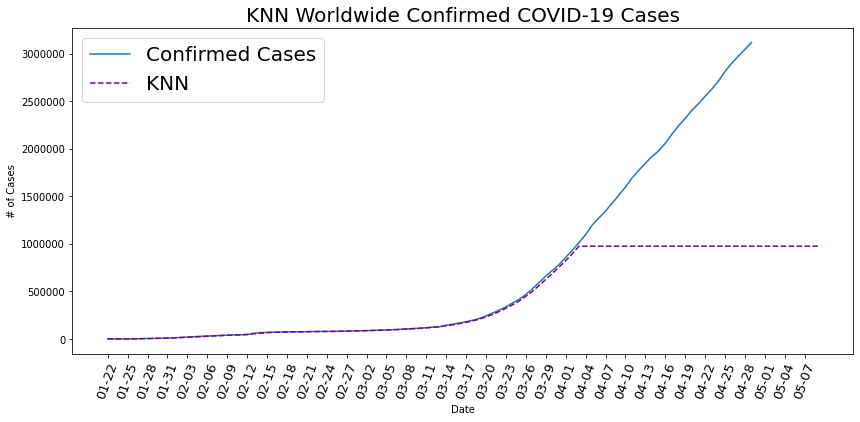

Runtime: 0.2745320796966553


In [29]:
t41=time.time()
plt.figure(figsize=(14, 6))
plt.plot(adjusted_dates, world_confirmed)
plt.plot(future_range_dates_short, neighbors_world_conf_pred, linestyle='dashed', color='purple')
plt.title('KNN Worldwide Confirmed COVID-19 Cases', size=20)
plt.xlabel('Date', size=10)
plt.ylabel('# of Cases', size=10)
plt.legend(['Confirmed Cases', 'KNN'], prop={'size': 20})
plt.xticks(np.arange(len(future_range_dates), step=3),size=13, rotation=70)
plt.yticks(size=10)
ax = plt.gca()
ax.yaxis.get_major_formatter().set_scientific(False)
plt.show()
t42=time.time()
print('Runtime:', t42-t41)

## Bayesian Ridge

In [30]:
t43=time.time()
tol = [1e-4, 1e-3, 1e-2]
alpha_1 = [1e-7, 1e-6, 1e-5, 1e-4]
alpha_2 = [1e-7, 1e-6, 1e-5, 1e-4]
lambda_1 = [1e-7, 1e-6, 1e-5, 1e-4]
lambda_2 = [1e-7, 1e-6, 1e-5, 1e-4]

bayesian_grid = {'tol': tol, 'alpha_1': alpha_1, 'alpha_2' : alpha_2, 'lambda_1': lambda_1, 'lambda_2' : lambda_2}

bayesian = BayesianRidge(fit_intercept=False, normalize=True)
bayesian_search = RandomizedSearchCV(bayesian, bayesian_grid, scoring='neg_mean_squared_error', cv=3, return_train_score=True, n_jobs=-1, n_iter=40, verbose=1)
bayesian_search.fit(poly_X_train_world_confirmed, y_train_world_confirmed)

bayesian_world_conf = bayesian_search.best_estimator_
test_bayesian_world_conf_pred = bayesian_world_conf.predict(poly_X_test_world_confirmed)
bayesian_world_conf_pred = bayesian_world_conf.predict(poly_future_world_forecast)

mAE_bayesian_world_conf = mean_absolute_error(y_test_world_confirmed, test_bayesian_world_conf_pred)
mSE_bayesian_world_conf = mean_squared_error(y_test_world_confirmed, test_bayesian_world_conf_pred)
mSLE_bayesian_world_conf = mean_squared_log_error(y_test_world_confirmed, test_bayesian_world_conf_pred)
rMSE_bayesian_world_conf = sqrt(mean_squared_error(y_test_world_confirmed, test_bayesian_world_conf_pred))
mAbE_bayesian_world_conf = median_absolute_error(y_test_world_confirmed, test_bayesian_world_conf_pred)
mAPE_bayesian_world_conf = mean_absolute_percentage_error(y_test_world_confirmed, test_bayesian_world_conf_pred)
r2_bayesian_world_conf = r2_score(y_test_world_confirmed, test_bayesian_world_conf_pred)
mPD_bayesian_world_conf = mean_poisson_deviance(y_test_world_confirmed, test_bayesian_world_conf_pred)
mGD_bayesian_world_conf = mean_gamma_deviance(y_test_world_confirmed, test_bayesian_world_conf_pred)
mTD_bayesian_world_conf = mean_tweedie_deviance(y_test_world_confirmed, test_bayesian_world_conf_pred)
mE_bayesian_world_conf = max_error(y_test_world_confirmed, test_bayesian_world_conf_pred)
mEVS_bayesian_world_conf = explained_variance_score(y_test_world_confirmed, test_bayesian_world_conf_pred)

print('Bayesian Ridge on Worldwide Confirmed Cases: ')
table = [[mAE_bayesian_world_conf,mSE_bayesian_world_conf,mSLE_bayesian_world_conf,
          rMSE_bayesian_world_conf,mAbE_bayesian_world_conf,mAPE_bayesian_world_conf,
          r2_bayesian_world_conf,mPD_bayesian_world_conf,mGD_bayesian_world_conf,
          mTD_bayesian_world_conf,mE_bayesian_world_conf,mEVS_bayesian_world_conf]]
headName = ['Mean Absolute Err', 'Mean Squared Err', 'Mean Squared Log Err', 'Root Mean Squared Err', 
            'Median Absolute Err', 'Mean Absolute Percentage Err', 'R2 Score', 
            'Mean Poisson Deviance', 'Mean Gamma Deviance', 'Mean Tweedie Deviance', 
           'Max Error', 'Explained Variance Score']
display(HTML(tabulate.tabulate(table, tablefmt='html', headers=headName)))
t44=time.time()
print('Runtime:', t44-t43)

Fitting 3 folds for each of 40 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 5 concurrent workers.


Bayesian Ridge on Worldwide Confirmed Cases: 


[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:    0.6s finished


Mean Absolute Err,Mean Squared Err,Mean Squared Log Err,Root Mean Squared Err,Median Absolute Err,Mean Absolute Percentage Err,R2 Score,Mean Poisson Deviance,Mean Gamma Deviance,Mean Tweedie Deviance,Max Error,Explained Variance Score
543574,6.02021e+11,0.0522695,775900,326164,20.6601,-0.791507,164706,0.0467806,6.02021e+11,1.8154e+06,0.00802307


Runtime: 0.6356747150421143


In [31]:
t45=time.time()
bayesian_world_conf_pred = bayesian_world_conf_pred.reshape(1,-1)[0]
print('Bayesian Ridge Worldwide Confirmed Cases Future Predictions: ')
t46=time.time()
print('Runtime:', t46-t45)
set(zip(future_range_dates[-10:], np.round(bayesian_world_conf_pred[-10:])))

Bayesian Ridge Worldwide Confirmed Cases Future Predictions: 
Runtime: 0.0009887218475341797


{('2020-04-29', 5201540.0),
 ('2020-04-30', 5482935.0),
 ('2020-05-01', 5776363.0),
 ('2020-05-02', 6082205.0),
 ('2020-05-03', 6400850.0),
 ('2020-05-04', 6732695.0),
 ('2020-05-05', 7078145.0),
 ('2020-05-06', 7437615.0),
 ('2020-05-07', 7811526.0),
 ('2020-05-08', 8200309.0)}

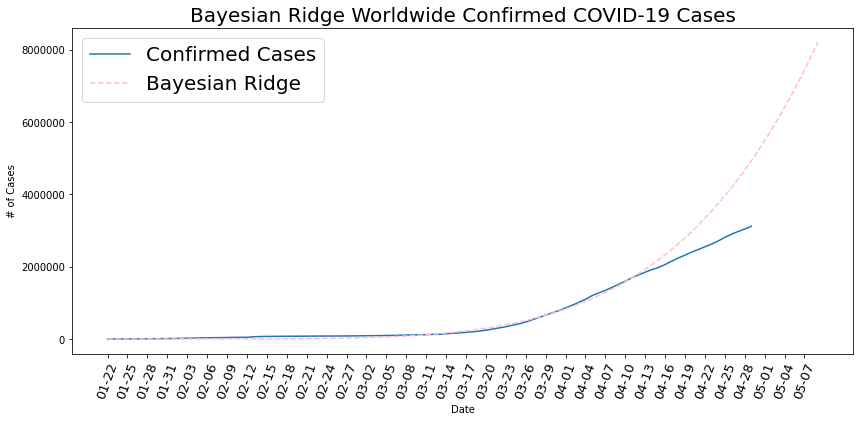

Runtime: 0.2966136932373047


In [32]:
t47=time.time()
plt.figure(figsize=(14, 6))
plt.plot(adjusted_dates, world_confirmed)
plt.plot(future_range_dates_short, bayesian_world_conf_pred, linestyle='dashed', color='pink')
plt.title('Bayesian Ridge Worldwide Confirmed COVID-19 Cases', size=20)
plt.xlabel('Date', size=10)
plt.ylabel('# of Cases', size=10)
plt.legend(['Confirmed Cases', 'Bayesian Ridge'], prop={'size': 20})
plt.xticks(np.arange(len(future_range_dates), step=3),size=13, rotation=70)
plt.yticks(size=10)
ax = plt.gca()
ax.yaxis.get_major_formatter().set_scientific(False)
plt.show()
t48=time.time()
print('Runtime:', t48-t47)

## Decision Tree Regressor

In [33]:
t49=time.time()
decisionTree_world_conf = DecisionTreeRegressor(random_state=0)
decisionTree_world_conf.fit(X_train_world_confirmed, y_train_world_confirmed)

test_decisionTree_world_conf = decisionTree_world_conf.predict(X_test_world_confirmed)
decisionTree_world_conf_pred = decisionTree_world_conf.predict(future_range)

mAE_decTree_world_conf = mean_absolute_error(y_test_world_confirmed, test_decisionTree_world_conf)
mSE_decTree_world_conf = mean_squared_error(y_test_world_confirmed, test_decisionTree_world_conf)
mSLE_decTree_world_conf = mean_squared_log_error(y_test_world_confirmed, test_decisionTree_world_conf)
rMSE_decTree_world_conf = sqrt(mean_squared_error(y_test_world_confirmed, test_decisionTree_world_conf))
mAbE_decTree_world_conf = median_absolute_error(y_test_world_confirmed, test_decisionTree_world_conf)
mAPE_decTree_world_conf = mean_absolute_percentage_error(y_test_world_confirmed, test_decisionTree_world_conf)
r2_decTree_world_conf = r2_score(y_test_world_confirmed, test_decisionTree_world_conf)
mPD_decTree_world_conf = mean_poisson_deviance(y_test_world_confirmed, test_decisionTree_world_conf)
mGD_decTree_world_conf = mean_gamma_deviance(y_test_world_confirmed, test_decisionTree_world_conf)
mTD_decTree_world_conf = mean_tweedie_deviance(y_test_world_confirmed, test_decisionTree_world_conf)
mE_decTree_world_conf = max_error(y_test_world_confirmed, test_decisionTree_world_conf)
mEVS_decTree_world_conf = explained_variance_score(y_test_world_confirmed, test_decisionTree_world_conf)

print('Decision Tree on Worldwide Confirmed Cases: ')
table = [[mAE_decTree_world_conf,mSE_decTree_world_conf,mSLE_decTree_world_conf,
          rMSE_decTree_world_conf,mAbE_decTree_world_conf,mAPE_decTree_world_conf,
          r2_decTree_world_conf,mPD_decTree_world_conf,mGD_decTree_world_conf,
          mTD_decTree_world_conf,mE_decTree_world_conf,mEVS_decTree_world_conf]]
headName = ['Mean Absolute Err', 'Mean Squared Err', 'Mean Squared Log Err', 'Root Mean Squared Err', 
            'Median Absolute Err', 'Mean Absolute Percentage Err', 'R2 Score', 
            'Mean Poisson Deviance', 'Mean Gamma Deviance', 'Mean Tweedie Deviance', 
           'Max Error', 'Explained Variance Score']
display(HTML(tabulate.tabulate(table, tablefmt='html', headers=headName)))
t50=time.time()
print('Runtime:', t50-t49)

Decision Tree on Worldwide Confirmed Cases: 


Mean Absolute Err,Mean Squared Err,Mean Squared Log Err,Root Mean Squared Err,Median Absolute Err,Mean Absolute Percentage Err,R2 Score,Mean Poisson Deviance,Mean Gamma Deviance,Mean Tweedie Deviance,Max Error,Explained Variance Score
1.06048e+06,1.46066e+12,0.487738,1.20858e+06,1.05673e+06,44.9474,-3.34667,957480,0.659054,1.46066e+12,2.02048e+06,0


Runtime: 0.009552717208862305


In [34]:
#decisionTree_world_conf_pred

In [35]:
t51=time.time()
decisionTree_world_conf_pred = decisionTree_world_conf_pred.reshape(1,-1)[0]
print('Decision Tree Worldwide Confirmed Cases Future Predictions: ')
t52=time.time()
print('Runtime:', t52-t51)
set(zip(future_range_dates[-10:], np.round(decisionTree_world_conf_pred[-10:])))

Decision Tree Worldwide Confirmed Cases Future Predictions: 
Runtime: 0.0004994869232177734


{('2020-04-29', 1095917.0),
 ('2020-04-30', 1095917.0),
 ('2020-05-01', 1095917.0),
 ('2020-05-02', 1095917.0),
 ('2020-05-03', 1095917.0),
 ('2020-05-04', 1095917.0),
 ('2020-05-05', 1095917.0),
 ('2020-05-06', 1095917.0),
 ('2020-05-07', 1095917.0),
 ('2020-05-08', 1095917.0)}

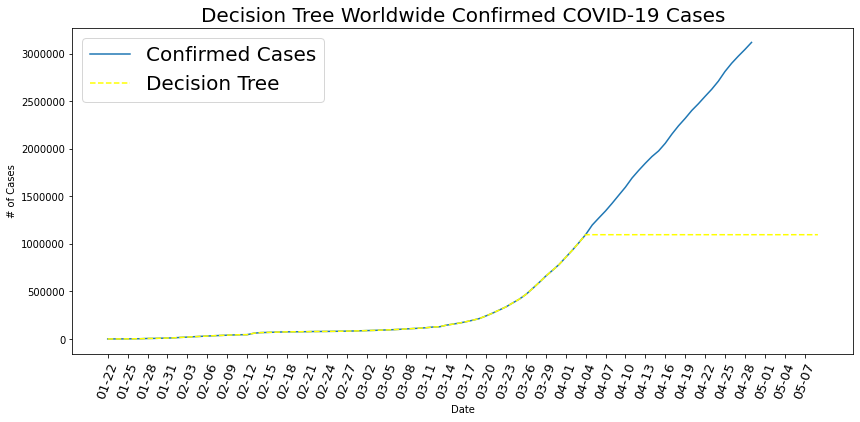

Runtime: 0.6421573162078857


In [36]:
t53=time.time()
plt.figure(figsize=(14, 6))
plt.plot(adjusted_dates, world_confirmed)
plt.plot(future_range_dates_short, decisionTree_world_conf_pred, linestyle='dashed', color='yellow')
plt.title('Decision Tree Worldwide Confirmed COVID-19 Cases', size=20)
plt.xlabel('Date', size=10)
plt.ylabel('# of Cases', size=10)
plt.legend(['Confirmed Cases', 'Decision Tree'], prop={'size': 20})
plt.xticks(np.arange(len(future_range_dates), step=3),size=13, rotation=70)
plt.yticks(size=10)
ax = plt.gca()
ax.yaxis.get_major_formatter().set_scientific(False)
plt.show()
t54=time.time()
print('Runtime:', t54-t53)

## Random Forest Regressor

In [37]:
t55=time.time()
#randomForest_world_conf = RandomForestRegressor(n_estimators=10, random_state=0)
#randomForest_world_conf.fit(X_train_world_confirmed, y_train_world_confirmed)
#randomForest_world_conf = RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=30,
#           max_features='sqrt', max_leaf_nodes=None,
#           min_impurity_decrease=0.0, min_impurity_split=None,
#           min_samples_leaf=2, min_samples_split=5,
#           min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=1,
#           oob_score=False, random_state=None, verbose=0, warm_start=False)
#randomForest_world_conf.fit(X_train_world_confirmed , y_train_world_confirmed)

#forest = RandomForestRegressor(n_jobs=-1)
#forest.fit(X_train_world_confirmed, y_train_world_confirmed)
rf_f = RandomForestRegressor(n_estimators=100, n_jobs= -1, min_samples_leaf=3, random_state=17)

rf_f.fit(X_train_world_confirmed,y_train_world_confirmed)
#param_grid = [
#{'n_estimators': [10, 25], 'max_features': [5, 10], 
# 'max_depth': [10, 50, None], 'bootstrap': [True, False]}
#]

#grid_search_forest = GridSearchCV(forest, param_grid, cv=10, scoring='neg_mean_squared_error')
#grid_search_forest.fit(X_train_world_confirmed, y_train_world_confirmed)

#randomFor_world_conf = grid_search_forest.best_estimator_
#test_randomForest_world_conf = randomFor_world_conf.predict(X_test_world_confirmed)
#randomFor_world_conf_pred = randomFor_world_conf.predict(future_range)

test_randomForest_world_conf = rf_f.predict(X_test_world_confirmed)
randomForest_world_conf_pred = rf_f.predict(future_range)

mAE_ranFor_world_conf = mean_absolute_error(y_test_world_confirmed, test_randomForest_world_conf)
mSE_ranFor_world_conf = mean_squared_error(y_test_world_confirmed, test_randomForest_world_conf)
mSLE_ranFor_world_conf = mean_squared_log_error(y_test_world_confirmed, test_randomForest_world_conf)
rMSE_ranFor_world_conf = sqrt(mean_squared_error(y_test_world_confirmed, test_randomForest_world_conf))
mAbE_ranFor_world_conf = median_absolute_error(y_test_world_confirmed, test_randomForest_world_conf)
mAPE_ranFor_world_conf = mean_absolute_percentage_error(y_test_world_confirmed, test_randomForest_world_conf)
r2_ranFor_world_conf = r2_score(y_test_world_confirmed, test_randomForest_world_conf)
mPD_ranFor_world_conf = mean_poisson_deviance(y_test_world_confirmed, test_randomForest_world_conf)
mGD_ranFor_world_conf = mean_gamma_deviance(y_test_world_confirmed, test_randomForest_world_conf)
mTD_ranFor_world_conf = mean_tweedie_deviance(y_test_world_confirmed, test_randomForest_world_conf)
mE_ranFor_world_conf = max_error(y_test_world_confirmed, test_randomForest_world_conf)
mEVS_ranFor_world_conf = explained_variance_score(y_test_world_confirmed, test_randomForest_world_conf)

print('Random Forest on Worldwide Confirmed Cases: ')
table = [[mAE_ranFor_world_conf,mSE_ranFor_world_conf,mSLE_ranFor_world_conf,
          rMSE_ranFor_world_conf,mAbE_ranFor_world_conf,mAPE_ranFor_world_conf,
          r2_ranFor_world_conf,mPD_ranFor_world_conf,mGD_ranFor_world_conf,
          mTD_ranFor_world_conf,mE_ranFor_world_conf,mEVS_ranFor_world_conf]]
headName = ['Mean Absolute Err', 'Mean Squared Err', 'Mean Squared Log Err', 'Root Mean Squared Err', 
            'Median Absolute Err', 'Mean Absolute Percentage Err', 'R2 Score', 
            'Mean Poisson Deviance', 'Mean Gamma Deviance', 'Mean Tweedie Deviance', 
           'Max Error', 'Explained Variance Score']
display(HTML(tabulate.tabulate(table, tablefmt='html', headers=headName)))
t56=time.time()
print('Runtime:', t56-t55)

Random Forest on Worldwide Confirmed Cases: 


Mean Absolute Err,Mean Squared Err,Mean Squared Log Err,Root Mean Squared Err,Median Absolute Err,Mean Absolute Percentage Err,R2 Score,Mean Poisson Deviance,Mean Gamma Deviance,Mean Tweedie Deviance,Max Error,Explained Variance Score
1.2751e+06,1.96192e+12,0.813407,1.40069e+06,1.27135e+06,55.7287,-4.83833,1.46822e+06,1.18151,1.96192e+12,2.2351e+06,0


Runtime: 0.46660780906677246


In [38]:
#randomForest_world_conf_pred

In [39]:
t57=time.time()
randomForest_world_conf_pred = randomForest_world_conf_pred.reshape(1,-1)[0]
print('Random Forest Worldwide Confirmed Cases Future Predictions: ')
t58=time.time()
print('Runtime:', t58-t57)
set(zip(future_range_dates[-10:], np.round(randomForest_world_conf_pred[-10:])))

Random Forest Worldwide Confirmed Cases Future Predictions: 
Runtime: 0.0001628398895263672


{('2020-04-29', 881298.0),
 ('2020-04-30', 881298.0),
 ('2020-05-01', 881298.0),
 ('2020-05-02', 881298.0),
 ('2020-05-03', 881298.0),
 ('2020-05-04', 881298.0),
 ('2020-05-05', 881298.0),
 ('2020-05-06', 881298.0),
 ('2020-05-07', 881298.0),
 ('2020-05-08', 881298.0)}

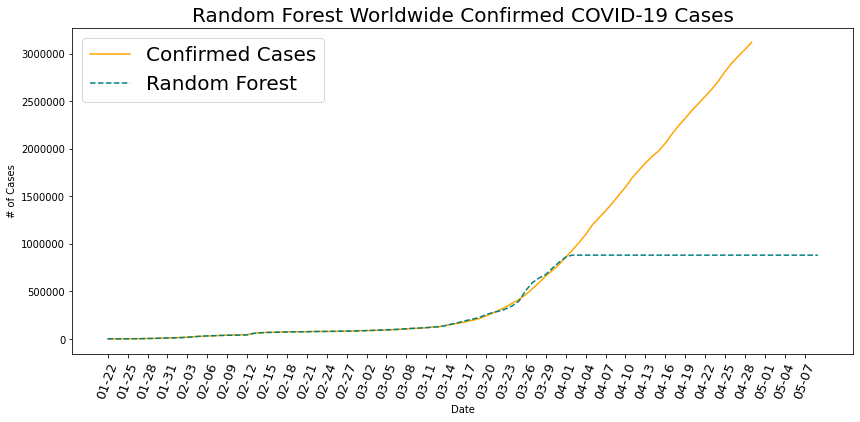

Runtime: 0.27702975273132324


In [40]:
t59=time.time()
plt.figure(figsize=(14, 6))
plt.plot(adjusted_dates, world_confirmed, color='orange')
plt.plot(future_range_dates_short, randomForest_world_conf_pred, linestyle='dashed', color='teal')
plt.title('Random Forest Worldwide Confirmed COVID-19 Cases', size=20)
plt.xlabel('Date', size=10)
plt.ylabel('# of Cases', size=10)
plt.legend(['Confirmed Cases', 'Random Forest'], prop={'size': 20})
plt.xticks(np.arange(len(future_range_dates), step=3),size=13, rotation=70)
plt.yticks(size=10)
ax = plt.gca()
ax.yaxis.get_major_formatter().set_scientific(False)
plt.show()
t60=time.time()
print('Runtime:', t60-t59)

In [41]:
covidFilled.groupby(["Date", "Country", "Province_State"])[['Date', 'Province_State', 'Country', 'Confirmed', 'Deaths', 'Recovered']].sum().reset_index()

,Date,Country,Province_State,Confirmed,Deaths,Recovered
0,2020-01-22,Hong Kong,Hong Kong,0.0,0.0,0.0
1,2020-01-22,Macau,Macau,1.0,0.0,0.0
2,2020-01-22,Mainland China,Anhui,1.0,0.0,0.0
3,2020-01-22,Mainland China,Beijing,14.0,0.0,0.0
4,2020-01-22,Mainland China,Chongqing,6.0,0.0,0.0
...,...,...,...,...,...,...
9601,2020-04-28,United Kingdom,Falkland Islands (Malvinas),13.0,0.0,11.0
9602,2020-04-28,United Kingdom,Gibraltar,141.0,0.0,131.0
9603,2020-04-28,United Kingdom,Isle of Man,309.0,21.0,252.0
9604,2020-04-28,United Kingdom,Montserrat,11.0,1.0,2.0


In [42]:
covidFilled.groupby("Country")[['Confirmed', 'Deaths', 'Recovered']].last().reset_index()

,Country,Confirmed,Deaths,Recovered
0,Azerbaijan,1.0,0.0,0.0
1,Afghanistan,1828.0,58.0,228.0
2,Albania,750.0,30.0,431.0
3,Algeria,3649.0,437.0,1651.0
4,Andorra,743.0,41.0,398.0
...,...,...,...,...
230,Western Sahara,6.0,0.0,5.0
231,Yemen,1.0,0.0,1.0
232,Zambia,95.0,3.0,42.0
233,Zimbabwe,32.0,4.0,5.0


In [43]:
covidFilled.groupby('Date').sum()[['Confirmed', 'Deaths', 'Recovered']].reset_index()

,Date,Confirmed,Deaths,Recovered
0,2020-01-22,555.0,17.0,28.0
1,2020-01-23,653.0,18.0,30.0
2,2020-01-24,941.0,26.0,36.0
3,2020-01-25,1438.0,42.0,39.0
4,2020-01-26,2118.0,56.0,52.0
...,...,...,...,...
93,2020-04-24,2810715.0,197151.0,793420.0
94,2020-04-25,2896746.0,202846.0,816685.0
95,2020-04-26,2971475.0,206544.0,865733.0
96,2020-04-27,3041764.0,211167.0,893967.0


## Keras

In [44]:
t61=time.time()
df_per_day = datesGroup.groupby('Date')['Confirmed'].sum()

df_per_day.index =  pd.to_datetime(df_per_day.index)
daily_cases = df_per_day.diff().fillna(df_per_day[0]).astype(np.int64)
df_keras_pred = pd.DataFrame(data=svm_world_conf_pred[-10:])
keras_predict_data = df_keras_pred.diff().fillna(df_keras_pred[0]).astype(np.int64).stack()
keras_predict_data[0][0] = 0


keras_train_data = daily_cases[:-15]
keras_train_data2 = daily_cases[:-15]
keras_test_data  = daily_cases[-15:]

sc = MinMaxScaler(feature_range=(0, 1))
sc = sc.fit(np.expand_dims(keras_train_data,axis=1))
keras_train_data = sc.transform(np.expand_dims(keras_train_data,axis=1))
keras_test_data  = sc.transform(np.expand_dims(keras_test_data,axis=1))
keras_predict_data = sc.transform(np.expand_dims(keras_predict_data,axis=1))
#keras_predict_data
t62=time.time()
print('Runtime:', t62-t61)

Runtime: 0.007334470748901367


In [45]:
def prep(dataPart,seq):
    x = []
    y = []
    for i in range(len(dataPart)-seq-1):
        x_ = dataPart[i:i+seq]
        y_ = dataPart[i+seq]
        x.append(x_)
        y.append(y_)
    return np.array(x),np.array(y)

X_keras_train,Y_keras_train  = prep(keras_train_data,5)
X_keras_test,Y_keras_test  = prep(keras_test_data,5)
X_keras_predict,Y_keras_predict  = prep(keras_predict_data,5)
#Y_keras_predict

In [46]:
t63=time.time()
kModel = Sequential()
kModel.add(LSTM(units=50,return_sequences=True,input_shape=(X_keras_train.shape[1],1)))
kModel.add(Dropout(0.2))
kModel.add(LSTM(units=100,return_sequences=True))
kModel.add(Dropout(0.2))
kModel.add(LSTM(units=100,return_sequences=True))
kModel.add(Dropout(0.2))
kModel.add(LSTM(units=50,return_sequences=True))
kModel.add(Dropout(0.2))
kModel.add(LSTM(units=50))
kModel.add(Dropout(0.2))
kModel.add(Dense(units=1))
t64=time.time()
print('Runtime:', t64-t63)

Runtime: 1.0108468532562256


In [47]:
t65=time.time()
kModel.compile(optimizer='adam',loss='mean_squared_error')
kModel.fit(X_keras_train,Y_keras_train,epochs=100,validation_data=(X_keras_test,Y_keras_test))
t66=time.time()
print('Runtime:', t66-t65)

Train on 77 samples, validate on 9 samples
Epoch 1/100
77/77 [==============================] - 2s 27ms/step - loss: 0.1462 - val_loss: 0.5761
Epoch 2/100
77/77 [==============================] - 0s 871us/step - loss: 0.1281 - val_loss: 0.4905
Epoch 3/100
77/77 [==============================] - 0s 874us/step - loss: 0.1085 - val_loss: 0.3647
Epoch 4/100
77/77 [==============================] - 0s 911us/step - loss: 0.0830 - val_loss: 0.1989
Epoch 5/100
77/77 [==============================] - 0s 942us/step - loss: 0.0845 - val_loss: 0.0850
Epoch 6/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0826 - val_loss: 0.0967
Epoch 7/100
77/77 [==============================] - 0s 1ms/step - loss: 0.0601 - val_loss: 0.0962
Epoch 8/100
77/77 [==============================] - 0s 713us/step - loss: 0.0459 - val_loss: 0.0608
Epoch 9/100
77/77 [==============================] - 0s 617us/step - loss: 0.0303 - val_loss: 0.0174
Epoch 10/100
77/77 [==============================] -

77/77 [==============================] - 0s 614us/step - loss: 0.0043 - val_loss: 0.0101
Epoch 82/100


/home/cyphersloth/.local/lib/python3.7/site-packages/keras/callbacks/callbacks.py:95: RuntimeWarning:

Method (on_train_batch_end) is slow compared to the batch update (0.171812). Check your callbacks.



77/77 [==============================] - 0s 603us/step - loss: 0.0046 - val_loss: 0.0101
Epoch 83/100
77/77 [==============================] - 0s 655us/step - loss: 0.0045 - val_loss: 0.0107
Epoch 84/100
77/77 [==============================] - 0s 537us/step - loss: 0.0041 - val_loss: 0.0152
Epoch 85/100
77/77 [==============================] - 0s 646us/step - loss: 0.0038 - val_loss: 0.0165
Epoch 86/100
77/77 [==============================] - 0s 615us/step - loss: 0.0055 - val_loss: 0.0112
Epoch 87/100
77/77 [==============================] - 0s 589us/step - loss: 0.0040 - val_loss: 0.0103
Epoch 88/100
77/77 [==============================] - 0s 607us/step - loss: 0.0043 - val_loss: 0.0120
Epoch 89/100
77/77 [==============================] - 0s 542us/step - loss: 0.0048 - val_loss: 0.0103
Epoch 90/100
77/77 [==============================] - 0s 544us/step - loss: 0.0038 - val_loss: 0.0110
Epoch 91/100
77/77 [==============================] - 0s 537us/step - loss: 0.0050 - val_loss: 

In [48]:
t67=time.time()
keras_future_pred = kModel.predict(X_keras_predict)
keras_future_pred = sc.inverse_transform(keras_future_pred)
keras_future_pred = np.reshape(keras_future_pred, (len(keras_future_pred),))

keras_pred = kModel.predict(X_keras_test)
keras_pred = sc.inverse_transform(keras_pred)
keras_pred = np.reshape(keras_pred, (len(keras_pred),))

keras_real = sc.inverse_transform(Y_keras_test)
keras_real = keras_real.astype('int64')
keras_real = np.concatenate(keras_real).ravel()

keras_full = sc.inverse_transform(keras_train_data)
keras_full = np.concatenate(keras_full).ravel()

keras_pred_conf =  np.concatenate((keras_full,keras_pred, keras_pred, keras_future_pred, keras_future_pred))
keras_real_conf = np.concatenate((keras_full,keras_real))
t68=time.time()
print('Runtime:', t68-t67)

Runtime: 0.36463212966918945


In [49]:
t69=time.time()
mAE_keras_world_conf = mean_absolute_error(keras_real, keras_pred)
mSE_keras_world_conf = mean_squared_error(keras_real, keras_pred)
mSLE_keras_world_conf = mean_squared_log_error(keras_real, keras_pred)
rMSE_keras_world_conf = sqrt(mean_squared_error(keras_real, keras_pred))
mAbE_keras_world_conf = median_absolute_error(keras_real, keras_pred)
mAPE_keras_world_conf = mean_absolute_percentage_error(keras_real, keras_pred)
r2_keras_world_conf = r2_score(keras_real, keras_pred)
mPD_keras_world_conf = mean_poisson_deviance(keras_real, keras_pred)
mGD_keras_world_conf = mean_gamma_deviance(keras_real, keras_pred)
mTD_keras_world_conf = mean_tweedie_deviance(keras_real, keras_pred)
mE_keras_world_conf = max_error(keras_real, keras_pred)
mEVS_keras_world_conf = explained_variance_score(keras_real, keras_pred)

print('Keras on Worldwide Confirmed Cases: ')
table = [[mAE_keras_world_conf,mSE_keras_world_conf,mSLE_keras_world_conf,
          rMSE_keras_world_conf,mAbE_keras_world_conf,mAPE_keras_world_conf,
          r2_keras_world_conf,mPD_keras_world_conf,mGD_keras_world_conf,
          mTD_keras_world_conf,mE_keras_world_conf,mEVS_keras_world_conf]]
headName = ['Mean Absolute Err', 'Mean Squared Err', 'Mean Squared Log Err', 'Root Mean Squared Err', 
            'Median Absolute Err', 'Mean Absolute Percentage Err', 'R2 Score', 
            'Mean Poisson Deviance', 'Mean Gamma Deviance', 'Mean Tweedie Deviance', 
           'Max Error', 'Explained Variance Score']
display(HTML(tabulate.tabulate(table, tablefmt='html', headers=headName)))
t70=time.time()
print('Runtime:', t70-t69)

Keras on Worldwide Confirmed Cases: 


Mean Absolute Err,Mean Squared Err,Mean Squared Log Err,Root Mean Squared Err,Median Absolute Err,Mean Absolute Percentage Err,R2 Score,Mean Poisson Deviance,Mean Gamma Deviance,Mean Tweedie Deviance,Max Error,Explained Variance Score
8683.96,1.06024e+08,0.015022,10296.8,8409.31,10.3988,-0.207545,1287.06,0.0156988,1.06024e+08,23246.5,-0.166569


Runtime: 0.01132512092590332


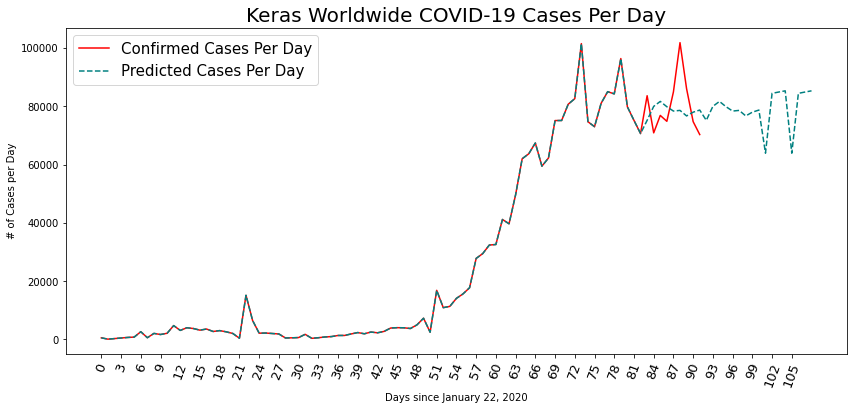

Runtime: 0.266430139541626


In [50]:
t71=time.time()
plt.figure(figsize=(14, 6))
plt.plot(keras_real_conf,color='red')
plt.plot(keras_pred_conf,linestyle='dashed',color='teal')
plt.title('Keras Worldwide COVID-19 Cases Per Day', size=20)
plt.xlabel('Days since January 22, 2020', size=10)
plt.ylabel('# of Cases per Day', size=10)
plt.legend(['Confirmed Cases Per Day', 'Predicted Cases Per Day'], prop={'size': 15})
plt.xticks(np.arange(len(future_range_dates), step=3),size=13, rotation=70)
plt.yticks(size=10)
ax = plt.gca()
ax.yaxis.get_major_formatter().set_scientific(False)
plt.show()
t72=time.time()
print('Runtime:', t72-t71)

In [51]:
t73=time.time()
keras_pred_conf = keras_pred_conf.cumsum().reshape(1,-1)[0]
print('Keras Worldwide Confirmed Cases Future Predictions: ')
t74=time.time()
print('Runtime:', t74-t73)
set(zip(future_range_dates[-10:], np.round(keras_pred_conf[-10:])))

Keras Worldwide Confirmed Cases Future Predictions: 
Runtime: 0.00017976760864257812


{('2020-04-29', 3252488.0),
 ('2020-04-30', 3331186.0),
 ('2020-05-01', 3395089.0),
 ('2020-05-02', 3479526.0),
 ('2020-05-03', 3564402.0),
 ('2020-05-04', 3649700.0),
 ('2020-05-05', 3713603.0),
 ('2020-05-06', 3798040.0),
 ('2020-05-07', 3882917.0),
 ('2020-05-08', 3968215.0)}

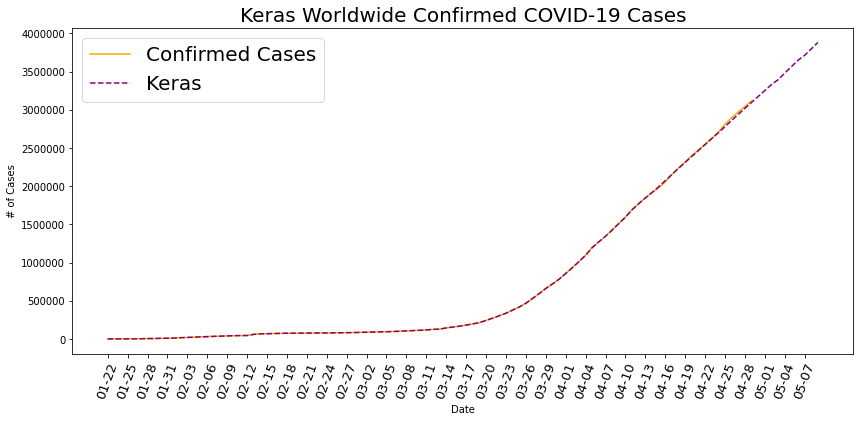

Runtime: 0.2824819087982178


In [52]:
t75=time.time()
plt.figure(figsize=(14, 6))
plt.plot(adjusted_dates,world_confirmed, color='orange')
plt.plot(future_range_dates_short,keras_pred_conf[:-1], linestyle='dashed', color='purple')
plt.title('Keras Worldwide Confirmed COVID-19 Cases', size=20)
plt.xlabel('Date', size=10)
plt.ylabel('# of Cases', size=10)
plt.legend(['Confirmed Cases', 'Keras'], prop={'size': 20})
plt.xticks(np.arange(len(future_range_dates), step=3),size=13, rotation=70)
plt.yticks(size=10)
ax = plt.gca()
ax.yaxis.get_major_formatter().set_scientific(False)
plt.show()
t76=time.time()
print('Runtime:', t76-t75)

## Prophet

In [53]:
t77=time.time()
proph_world_confirmed = covidFilled.groupby('Date').sum()['Confirmed'].reset_index()
proph_world_deaths = covidFilled.groupby('Date').sum()['Deaths'].reset_index()
proph_world_recovered = covidFilled.groupby('Date').sum()['Recovered'].reset_index()
proph_world_confirmed.columns = ['ds','y']
proph_world_confirmed['ds'] = pd.to_datetime(proph_world_confirmed['ds'])
#proph_world_confirmed.head()

proph_m_w_conf = Prophet(interval_width=0.95)
proph_m_w_conf.fit(proph_world_confirmed)
proph_future_world = proph_m_w_conf.make_future_dataframe(periods=10)
proph_future_world_confirmed = proph_future_world.copy()
#proph_future_world.tail()

proph_forecast_w_conf = proph_m_w_conf.predict(proph_future_world)
proph_w_conf = proph_forecast_w_conf[['yhat']]
t78=time.time()
print('Runtime:', t78-t77)
proph_forecast_w_conf[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

Runtime: 5.041345834732056


,ds,yhat,yhat_lower,yhat_upper
103,2020-05-04,3.601755e+06,3.548794e+06,3.657524e+06
104,2020-05-05,3.679155e+06,3.616742e+06,3.748226e+06
105,2020-05-06,3.757792e+06,3.682001e+06,3.837931e+06
106,2020-05-07,3.841183e+06,3.753776e+06,3.936745e+06
107,2020-05-08,3.926600e+06,3.828717e+06,4.039461e+06


In [54]:
t79=time.time()
metric_df = proph_forecast_w_conf.set_index('ds')[['yhat']].join(proph_world_confirmed.set_index('ds').y).reset_index()
metric_df.dropna(inplace=True)
t80=time.time()
print('Runtime:', t80-t79)

Runtime: 0.008132219314575195


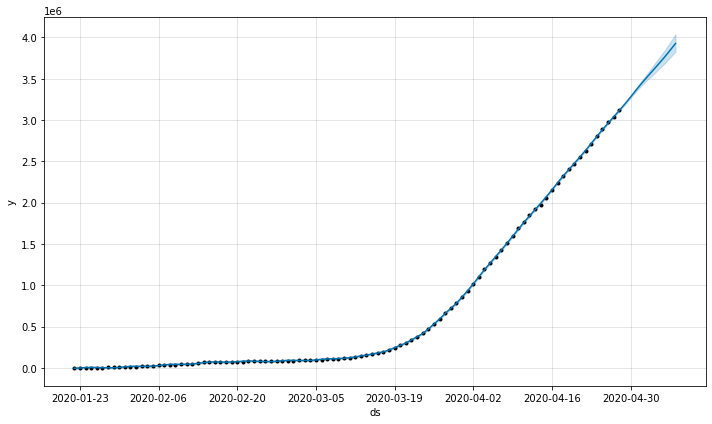

In [55]:
wor_confirmed_forecast_plot = proph_m_w_conf.plot(proph_forecast_w_conf)

In [56]:
t81=time.time()
mAE_proph_world_conf = mean_absolute_error(metric_df[['y']], metric_df[['yhat']])
mSE_proph_world_conf = mean_squared_error(metric_df[['y']], metric_df[['yhat']])
#mSLE_proph_world_conf = mean_squared_log_error(metric_df[['y']], metric_df[['yhat']])
rMSE_proph_world_conf = sqrt(mean_squared_error(metric_df[['y']], metric_df[['yhat']]))
mAbE_proph_world_conf = median_absolute_error(metric_df[['y']], metric_df[['yhat']])
mAPE_proph_world_conf = mean_absolute_percentage_error(metric_df[['y']], metric_df[['yhat']])
r2_proph_world_conf = r2_score(metric_df[['y']], metric_df[['yhat']])
#mPD_proph_world_conf = mean_poisson_deviance(metric_df[['y']], metric_df[['yhat']])
#mGD_proph_world_conf = mean_gamma_deviance(metric_df[['y']], metric_df[['yhat']])
mTD_proph_world_conf = mean_tweedie_deviance(metric_df[['y']], metric_df[['yhat']])
mE_proph_world_conf = max_error(metric_df[['y']], metric_df[['yhat']])
mEVS_proph_world_conf = explained_variance_score(metric_df[['y']], metric_df[['yhat']])

print('Prophet on Worldwide Confirmed Cases: ')

table = [[mAE_proph_world_conf,mSE_proph_world_conf,rMSE_proph_world_conf,
          mAbE_proph_world_conf,mAPE_proph_world_conf,r2_proph_world_conf,
          mTD_proph_world_conf,mE_proph_world_conf,mEVS_proph_world_conf]]
headName = ['Mean Absolute Err', 'Mean Squared Err', 'Root Mean Squared Err', 
            'Median Absolute Err', 'Mean Absolute Percentage Err', 'R2 Score', 
           'Mean Tweedie Deviance', 'Max Error', 'Explained Variance Score']
display(HTML(tabulate.tabulate(table, tablefmt='html', headers=headName)))
t82=time.time()
print('Runtime:', t82-t81)

Prophet on Worldwide Confirmed Cases: 


Mean Absolute Err,Mean Squared Err,Root Mean Squared Err,Median Absolute Err,Mean Absolute Percentage Err,R2 Score,Mean Tweedie Deviance,Max Error,Explained Variance Score
3541.6,2.28285e+07,4777.92,2744.38,23.7306,0.999974,2.28285e+07,16360.1,0.999974


Runtime: 0.039034128189086914


In [57]:
## World Confirmed Prophet Evaluation Metrics
t83=time.time()
df_cv = cross_validation(proph_m_w_conf, initial='60 days', period='3 days', horizon = '5 days')
#df_cv.head()
df_p = performance_metrics(df_cv)
t84=time.time()
print('Runtime:', t84-t83)
df_p.head()

Runtime: 29.394869089126587


,horizon,mse,rmse,mae,mape,mdape,coverage
0,1 days,6.510041e+09,80684.822650,64321.396181,0.073726,0.039140,0.181818
1,2 days,1.129336e+10,106270.223995,81867.636803,0.088286,0.050502,0.181818
2,3 days,1.639636e+10,128048.275470,95864.719862,0.098332,0.051633,0.454545
3,4 days,2.318454e+10,152264.715262,111541.206494,0.108182,0.051860,0.454545
4,5 days,3.241376e+10,180038.227088,132342.585187,0.118647,0.049366,0.454545


In [58]:
t85=time.time()
proph_world_deaths.columns = ['ds','y']
proph_world_deaths['ds'] = pd.to_datetime(proph_world_deaths['ds'])
proph_m_w_deaths = Prophet(interval_width=0.95)
proph_m_w_deaths.fit(proph_world_deaths)
proph_future_w_deaths = proph_m_w_deaths.make_future_dataframe(periods=10)
proph_future_deaths_w = proph_future_w_deaths.copy()

forecast_deaths_proph_w = proph_m_w_deaths.predict(proph_future_w_deaths)
t86=time.time()
print('Runtime:', t86-t85)
forecast_deaths_proph_w[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

Runtime: 3.277104616165161


,ds,yhat,yhat_lower,yhat_upper
103,2020-05-04,260984.404885,256645.421457,264737.058386
104,2020-05-05,267544.983076,262509.917733,272270.018711
105,2020-05-06,274608.704437,268610.308580,280121.606193
106,2020-05-07,281692.183152,274187.550047,287907.759575
107,2020-05-08,288695.038513,279805.226755,296087.048442


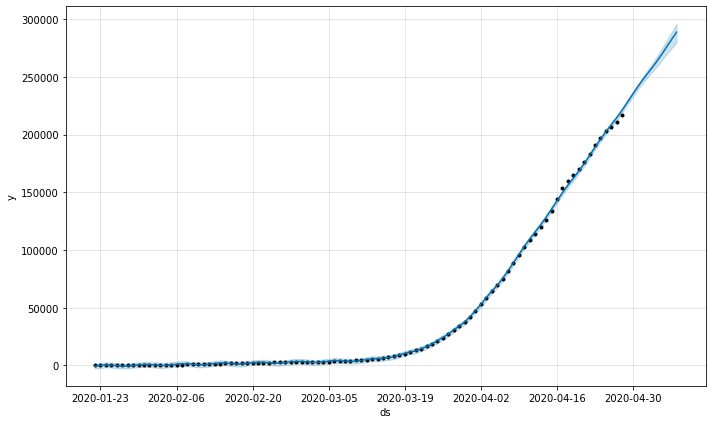

In [59]:
proph_w_deaths_forecast_plot = proph_m_w_deaths.plot(forecast_deaths_proph_w)

In [60]:
t87=time.time()
df_cv = cross_validation(proph_m_w_deaths, initial='60 days', period='3 days', horizon = '5 days')
#df_cv.head()
df_p = performance_metrics(df_cv)
t88=time.time()
print('Runtime:', t88-t87)
df_p.head()

Runtime: 27.27372932434082


,horizon,mse,rmse,mae,mape,mdape,coverage
0,1 days,5.988475e+07,7738.523589,6810.777294,0.119088,0.108861,0.181818
1,2 days,9.773357e+07,9886.029056,8707.589178,0.140839,0.127207,0.181818
2,3 days,1.455376e+08,12063.896390,10825.494134,0.161050,0.134511,0.090909
3,4 days,2.022829e+08,14222.617616,12752.285742,0.177829,0.138981,0.090909
4,5 days,2.832512e+08,16830.067286,14921.209740,0.193525,0.140902,0.090909


## Florida COVID-19 Case Predictions

In [61]:
t89=time.time()
proph_flconfirmed = covidFilled.query('Province_State=="Florida"').groupby('Date')[['Confirmed']].sum().reset_index()
proph_fldeaths = covidFilled.query('Province_State=="Florida"').groupby('Date')[['Deaths']].sum().reset_index()
proph_flrecovered = covidFilled.query('Province_State=="Florida"').groupby('Date')[['Recovered']].sum().reset_index()
proph_flconfirmed.columns = ['ds','y']
#flconfirmed['ds'] = flconfirmed['ds'].dt.date
proph_flconfirmed['ds'] = pd.to_datetime(proph_flconfirmed['ds'])
t90=time.time()
print('Runtime:', t90-t89)
proph_flconfirmed.tail()
#proph_flconfirmed.head()


Runtime: 0.04380464553833008


,ds,y
45,2020-04-24,30533.0
46,2020-04-25,30839.0
47,2020-04-26,31532.0
48,2020-04-27,32138.0
49,2020-04-28,32848.0


In [62]:
t91=time.time()
fl_m = Prophet(interval_width=0.95)
fl_m.fit(proph_flconfirmed)
fl_future = fl_m.make_future_dataframe(periods=10)
fl_future_confirmed = fl_future.copy()
#fl_future.tail()
fl_forecast = fl_m.predict(fl_future)
t92=time.time()
print('Runtime:', t92-t91)
fl_forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

Runtime: 2.4897758960723877


,ds,yhat,yhat_lower,yhat_upper
55,2020-05-04,37608.762772,36566.900850,38723.622533
56,2020-05-05,38348.145527,37043.618297,39731.953170
57,2020-05-06,38902.726372,37303.959340,40522.774158
58,2020-05-07,39866.960405,38021.128299,41893.763380
59,2020-05-08,40758.058047,38612.938220,43056.782896


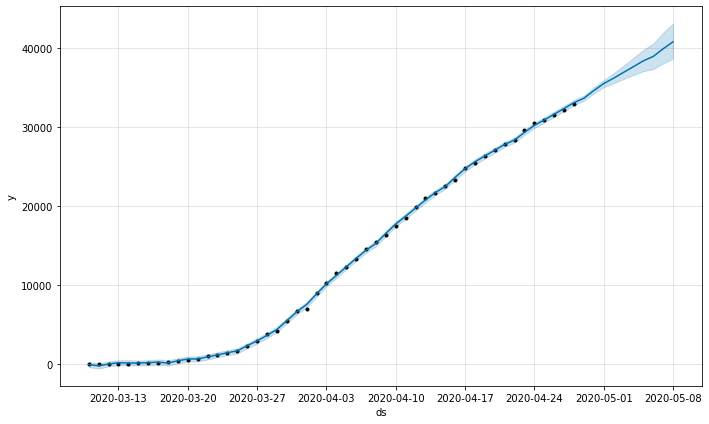

In [63]:
fl_confirmed_forecast_plot = fl_m.plot(fl_forecast)

In [64]:
t93=time.time()
proph_fldeaths.columns = ['ds','y']
proph_fldeaths['ds'] = pd.to_datetime(proph_fldeaths['ds'])
fl_m = Prophet(interval_width=0.95)
fl_m.fit(proph_fldeaths)
fl_future = fl_m.make_future_dataframe(periods=7)
fl_future_deaths = fl_future.copy() # for non-baseline predictions later on
#fl_future.tail()
fl_forecast = fl_m.predict(fl_future)
t94=time.time()
print('Runtime:', t94-t93)
fl_forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

Runtime: 2.3022468090057373


,ds,yhat,yhat_lower,yhat_upper
52,2020-05-01,1319.030216,1297.251185,1341.202257
53,2020-05-02,1355.330438,1329.608447,1381.597588
54,2020-05-03,1387.338816,1355.962543,1420.340568
55,2020-05-04,1423.488243,1383.364421,1460.158084
56,2020-05-05,1481.173688,1441.223207,1523.384743


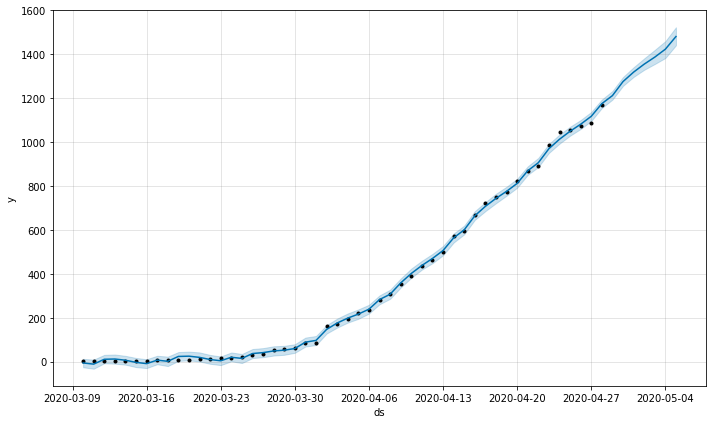

In [65]:
fl_deaths_forecast_plot = fl_m.plot(fl_forecast)

## SIR Model

Worldwide predictions

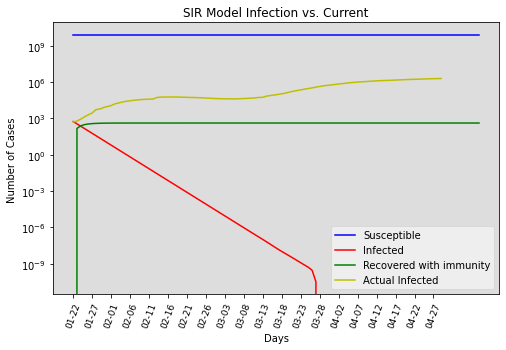

In [66]:
#Worldwide Estimated model 
world_confirmed = np.array(world_confirmed, dtype = float)
world_deaths = datesGroup['Deaths'].to_numpy()
world_recovered = datesGroup['Recovered'].to_numpy()
day_count = list(range(1,len(world_confirmed)+1))
day_count = np.array(day_count, dtype = float)

#Initialize values 
N = world_population
i_0 = world_confirmed[0]
r_0 = 0
s_0 = world_population - i_0 - r_0
b = 1/9
g = 1/3
t = np.linspace(0, 108, 108)

short_dates = []
for i in range(len(day_count)):
     short_dates.append((start_short + datetime.timedelta(days=i)).strftime('%m-%d'))

world_infected_actual = world_confirmed - (world_deaths + world_recovered)

def SIR(y, t, b, g):
    #initial values 
    s, i, r = y
    S = -b*s*i/N
    I = (-b*s*i/N) - g*i
    R = g*i   
    return [S, I, R]

result = odeint(SIR, [s_0, i_0, r_0], t, args=(b, g))
S, I, R = result.T
fig = plt.figure(figsize=(8,5))

ax = fig.add_subplot(111, facecolor='#dddddd', axisbelow=True)
ax.set_yscale('log')
ax.plot(future_range_dates_short, S, 'b', label='Susceptible')
ax.plot(future_range_dates_short, I, 'r', label='Infected')
ax.plot(future_range_dates_short, R, 'g', label='Recovered with immunity')
ax.plot(short_dates, world_infected_actual, 'y', label='Actual Infected')
ax.set_xlabel('Days')
ax.set_ylabel('Number of Cases ')
ax.set_title("SIR Model Infection vs. Current")
plt.xticks(np.arange(len(short_dates), step=5),size=9, rotation=70)
legend = ax.legend()
legend.get_frame().set_alpha(0.5)
plt.show()

/home/cyphersloth/.local/lib/python3.7/site-packages/scipy/integrate/odepack.py:248: ODEintWarning:

Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.



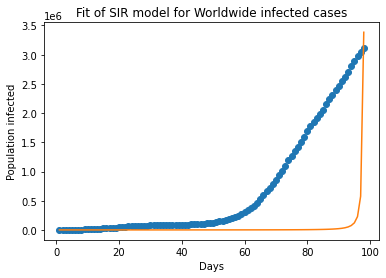

Optimal parameters: beta = 99.97564378713518  and gamma =  -99.96883838822276


/home/cyphersloth/.local/lib/python3.7/site-packages/scipy/integrate/odepack.py:248: ODEintWarning:

Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.



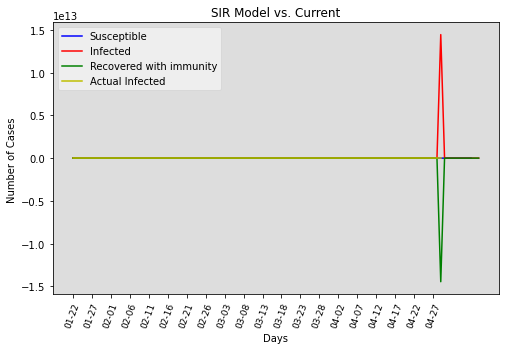

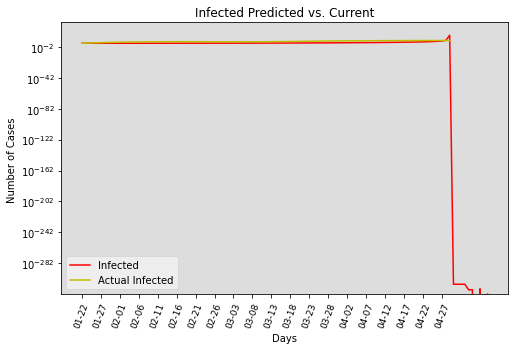

In [67]:
# Worldwide SIR Model

def fit_odeint(x, b, g):
    return integrate.odeint(SIR, (s_0, i_0, r_0), day_count, args=(b, g))[:,1]

popt, pcov = optimize.curve_fit(fit_odeint, day_count, world_confirmed)
fitted = fit_odeint(day_count, *popt)

# plotting fitted infected vs actual
plt.plot(day_count, world_confirmed, 'o')
plt.plot(day_count, fitted)
plt.title("Fit of SIR model for Worldwide infected cases")
plt.ylabel("Population infected")
plt.xlabel("Days")
plt.show()
print("Optimal parameters: beta =", popt[0], " and gamma = ", popt[1])

b = popt[0]
g= popt[1]
# result=fit_odeint(day_count, b, g)
# t = np.linspace(0, 83, 83)
result = odeint(SIR, [s_0, i_0, r_0], t, args=(b, g))
S, I, R = result.T
# t_np = np.array(t)

short_dates = []
for i in range(len(day_count)):
     short_dates.append((start_short + datetime.timedelta(days=i)).strftime('%m-%d'))

# plotting fitted SIR model values vs actual
fig = plt.figure(figsize=(8,5))
ax = fig.add_subplot(111, facecolor='#dddddd', axisbelow=True)
# ax.set_yscale('lin')
ax.plot(future_range_dates_short, S, 'b', label='Susceptible')
ax.plot(future_range_dates_short, I, 'r', label='Infected')
ax.plot(future_range_dates_short, R, 'g', label='Recovered with immunity')
ax.plot(short_dates, world_infected_actual, 'y', label='Actual Infected')
ax.set_xlabel('Days')
ax.set_ylabel('Number of Cases ')
ax.set_title("SIR Model vs. Current")
plt.xticks(np.arange(len(short_dates), step=5),size=9, rotation=70)
legend = ax.legend()
legend.get_frame().set_alpha(0.5)
plt.show()

# plotting fitted SIR model values vs actual
fig = plt.figure(figsize=(8,5))
ax = fig.add_subplot(111, facecolor='#dddddd', axisbelow=True)
ax.set_yscale('log')
ax.plot(future_range_dates_short, I, 'r', label='Infected')
ax.plot(short_dates, world_infected_actual, 'y', label='Actual Infected')
ax.set_xlabel('Days')
ax.set_ylabel('Number of Cases ')
ax.set_title("Infected Predicted vs. Current")
plt.xticks(np.arange(len(short_dates), step=5),size=9, rotation=70)
legend = ax.legend()
legend.get_frame().set_alpha(0.5)
plt.show()

In [68]:
# Calculating the SIR Model errors
mAE_sir_world_conf = mean_absolute_error(world_infected_actual, I[0:98])
mSE_sir_world_conf = mean_squared_error(world_infected_actual, I[0:98])
mSLE_sir_world_conf = mean_squared_log_error(world_infected_actual, I[0:98])
rMSE_sir_world_conf = sqrt(mean_squared_error(world_infected_actual, I[0:98]))
mAbE_sir_world_conf = median_absolute_error(world_infected_actual, I[0:98])
mAPE_sir_world_conf = mean_absolute_percentage_error(world_infected_actual, I[0:98])
r2_sir_world_conf = r2_score(world_infected_actual, I[0:98])
mPD_sir_world_conf = mean_poisson_deviance(world_infected_actual, I[0:98])
mGD_sir_world_conf = mean_gamma_deviance(world_infected_actual, I[0:98])
mTD_sir_world_conf = mean_tweedie_deviance(world_infected_actual, I[0:98])
mE_sir_world_conf = max_error(world_infected_actual, I[0:98])
mEVS_sir_world_conf = explained_variance_score(world_infected_actual, I[0:98])
print(mSLE_sir_world_conf)
print(mPD_sir_world_conf)
print(mGD_sir_world_conf)

21.210487686976045
294761966856.3723
198.16738133767572


In [69]:
print('SIR Model on Worldwide Confirmed Cases: ')
table = [[mAE_sir_world_conf,mSE_sir_world_conf,mSLE_sir_world_conf,
          rMSE_sir_world_conf,mAbE_sir_world_conf,mAPE_sir_world_conf,
          r2_sir_world_conf,mPD_sir_world_conf,mGD_sir_world_conf,
          mTD_sir_world_conf,mE_sir_world_conf,mEVS_sir_world_conf]]
headName = ['Mean Absolute Err', 'Mean Squared Err', 'Mean Squared Log Err', 'Root Mean Squared Err', 
            'Median Absolute Err', 'Mean Absolute Percentage Err', 'R2 Score', 
            'Mean Poisson Deviance', 'Mean Gamma Deviance', 'Mean Tweedie Deviance', 
           'Max Error', 'Explained Variance Score']
display(HTML(tabulate.tabulate(table, tablefmt='html', headers=headName)))

SIR Model on Worldwide Confirmed Cases: 


Mean Absolute Err,Mean Squared Err,Mean Squared Log Err,Root Mean Squared Err,Median Absolute Err,Mean Absolute Percentage Err,R2 Score,Mean Poisson Deviance,Mean Gamma Deviance,Mean Tweedie Deviance,Max Error,Explained Variance Score
1.4738e+11,2.12864e+24,21.2105,1.45899e+12,58102.7,7.47907e+06,-5.42255e+12,2.94762e+11,198.167,2.12864e+24,1.44432e+13,-5.36722e+12


Social Distancing Parameter

/home/cyphersloth/.local/lib/python3.7/site-packages/scipy/integrate/odepack.py:248: ODEintWarning:

Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.



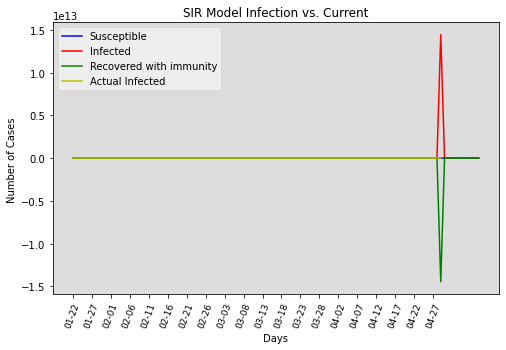

In [70]:
# SIR model with Social Distancing Parameter
p = 0.8

def SIR_distance(y, t, b, g):
    #initial values 
    s, i, r = y
    S = -pb*s*i/N
    I = (-pb*s*i/N) - g*i
    R = g*i   
    return [S, I, R]

result = odeint(SIR, [s_0, i_0, r_0], t, args=(b, g))
S, I, R = result.T
fig = plt.figure(figsize=(8,5))

ax = fig.add_subplot(111, facecolor='#dddddd', axisbelow=True)
# ax.set_yscale('log')
ax.plot(future_range_dates_short, S, 'b', label='Susceptible')
ax.plot(future_range_dates_short, I, 'r', label='Infected')
ax.plot(future_range_dates_short, R, 'g', label='Recovered with immunity')
ax.plot(short_dates, world_infected_actual, 'y', label='Actual Infected')
ax.set_xlabel('Days')
ax.set_ylabel('Number of Cases ')
ax.set_title("SIR Model Infection vs. Current")
plt.xticks(np.arange(len(short_dates), step=5),size=9, rotation=70)
legend = ax.legend()
legend.get_frame().set_alpha(0.5)
plt.show()

/home/cyphersloth/.local/lib/python3.7/site-packages/scipy/integrate/odepack.py:248: ODEintWarning:

Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.



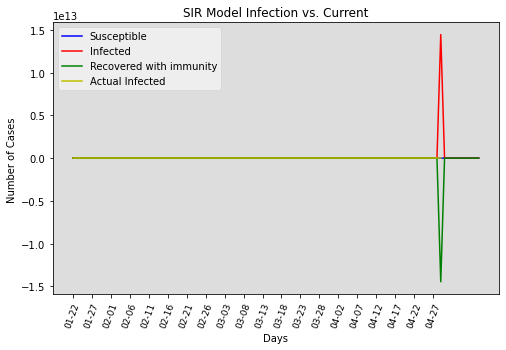

In [71]:
p = 0.5

def SIR_distance(y, t, b, g):
    #initial values 
    s, i, r = y
    S = -pb*s*i/N
    I = (-pb*s*i/N) - g*i
    R = g*i   
    return [S, I, R]

result = odeint(SIR, [s_0, i_0, r_0], t, args=(b, g))
S, I, R = result.T
fig = plt.figure(figsize=(8,5))

ax = fig.add_subplot(111, facecolor='#dddddd', axisbelow=True)
# ax.set_yscale('log')
ax.plot(future_range_dates_short, S, 'b', label='Susceptible')
ax.plot(future_range_dates_short, I, 'r', label='Infected')
ax.plot(future_range_dates_short, R, 'g', label='Recovered with immunity')
ax.plot(short_dates, world_infected_actual, 'y', label='Actual Infected')
ax.set_xlabel('Days')
ax.set_ylabel('Number of Cases ')
ax.set_title("SIR Model Infection vs. Current")
plt.xticks(np.arange(len(short_dates), step=5),size=9, rotation=70)
legend = ax.legend()
legend.get_frame().set_alpha(0.5)
plt.show()

## Worldwide Confirmed Cases Model Predictions

In [72]:
t95=time.time()
table = [[future_range_dates[-11:-10][0], np.round(linear_world_conf_pred[-11:-10]),
          np.round(poly_world_conf_pred[-11:-10]),np.round(svm_world_conf_pred[-11:-10]),
         np.round(xgb_world_conf_pred[-11:-10]),np.round(bayesian_world_conf_pred[-11:-10]),
         np.round(randomForest_world_conf_pred[-11:-10]),
         np.round(keras_pred_conf[-11:-10]),proph_forecast_w_conf[['yhat']][-11:-10].values[0][0]],
         [future_range_dates[-10:-9][0],np.round(linear_world_conf_pred[-10:-9]),
          np.round(poly_world_conf_pred[-10:-9]),np.round(svm_world_conf_pred[-10:-9]),
         np.round(xgb_world_conf_pred[-10:-9]),np.round(bayesian_world_conf_pred[-10:-9]),
         np.round(randomForest_world_conf_pred[-10:-9]),
         np.round(keras_pred_conf[-10:-9]),proph_forecast_w_conf[['yhat']][-10:-9].values[0][0]],
         [future_range_dates[-9:-8][0],np.round(linear_world_conf_pred[-9:-8]),
          np.round(poly_world_conf_pred[-9:-8]),np.round(svm_world_conf_pred[-9:-8]),
         np.round(xgb_world_conf_pred[-9:-8]),np.round(bayesian_world_conf_pred[-9:-8]),
         np.round(randomForest_world_conf_pred[-9:-8]),
         np.round(keras_pred_conf[-9:-8]),proph_forecast_w_conf[['yhat']][-9:-8].values[0][0]],
         [future_range_dates[-8:-7][0],np.round(linear_world_conf_pred[-8:-7]),
          np.round(poly_world_conf_pred[-8:-7]),np.round(svm_world_conf_pred[-8:-7]),
         np.round(xgb_world_conf_pred[-8:-7]),np.round(bayesian_world_conf_pred[-8:-7]),
         np.round(randomForest_world_conf_pred[-8:-7]),
         np.round(keras_pred_conf[-8:-7]),proph_forecast_w_conf[['yhat']][-8:-7].values[0][0]],
         [future_range_dates[-7:-6][0],np.round(linear_world_conf_pred[-7:-6]),
          np.round(poly_world_conf_pred[-7:-6]),np.round(svm_world_conf_pred[-7:-6]),
         np.round(xgb_world_conf_pred[-7:-6]),np.round(bayesian_world_conf_pred[-7:-6]),
         np.round(randomForest_world_conf_pred[-7:-6]),
         np.round(keras_pred_conf[-7:-6]),proph_forecast_w_conf[['yhat']][-7:-6].values[0][0]],
         [future_range_dates[-6:-5][0],np.round(linear_world_conf_pred[-6:-5]),
          np.round(poly_world_conf_pred[-6:-5]),np.round(svm_world_conf_pred[-6:-5]),
         np.round(xgb_world_conf_pred[-6:-5]),np.round(bayesian_world_conf_pred[-6:-5]),
         np.round(randomForest_world_conf_pred[-6:-5]),
         np.round(keras_pred_conf[-6:-5]),proph_forecast_w_conf[['yhat']][-6:-5].values[0][0]],
         [future_range_dates[-5:-4][0],np.round(linear_world_conf_pred[-5:-4]),
          np.round(poly_world_conf_pred[-5:-4]),np.round(svm_world_conf_pred[-5:-4]),
         np.round(xgb_world_conf_pred[-5:-4]),np.round(bayesian_world_conf_pred[-5:-4]),
         np.round(randomForest_world_conf_pred[-5:-4]),
         np.round(keras_pred_conf[-5:-4]),proph_forecast_w_conf[['yhat']][-5:-4].values[0][0]],
         [future_range_dates[-4:-3][0],np.round(linear_world_conf_pred[-4:-3]),
          np.round(poly_world_conf_pred[-4:-3]),np.round(svm_world_conf_pred[-4:-3]),
         np.round(xgb_world_conf_pred[-4:-3]),np.round(bayesian_world_conf_pred[-4:-3]),
         np.round(randomForest_world_conf_pred[-4:-3]),
         np.round(keras_pred_conf[-4:-3]),proph_forecast_w_conf[['yhat']][-4:-3].values[0][0]],
         [future_range_dates[-3:-2][0],np.round(linear_world_conf_pred[-3:-2]),
          np.round(poly_world_conf_pred[-3:-2]),np.round(svm_world_conf_pred[-3:-2]),
         np.round(xgb_world_conf_pred[-3:-2]),np.round(bayesian_world_conf_pred[-3:-2]),
         np.round(randomForest_world_conf_pred[-3:-2]),
         np.round(keras_pred_conf[-3:-2]),proph_forecast_w_conf[['yhat']][-3:-2].values[0][0]],
         [future_range_dates[-2:-1][0],np.round(linear_world_conf_pred[-2:-1]),
          np.round(poly_world_conf_pred[-2:-1]),np.round(svm_world_conf_pred[-2:-1]),
         np.round(xgb_world_conf_pred[-2:-1]),np.round(bayesian_world_conf_pred[-2:-1]),
         np.round(randomForest_world_conf_pred[-2:-1]),
         np.round(keras_pred_conf[-2:-1]),proph_forecast_w_conf[['yhat']][-2:-1].values[0][0]],
         [future_range_dates[-1:][0],np.round(linear_world_conf_pred[-1:]),
          np.round(poly_world_conf_pred[-1:]),np.round(svm_world_conf_pred[-1:]),
         np.round(xgb_world_conf_pred[-1:]),np.round(bayesian_world_conf_pred[-1:]),
         np.round(randomForest_world_conf_pred[-1:]),
         np.round(keras_pred_conf[-1:]),proph_forecast_w_conf[['yhat']][-1:].values[0][0]]]
headName = ['Date', 'Linear', 'Polynomial', 'SVM', 'XGBoost', 'Bayesian', 'Random Forest', 'Keras', 'Prophet']
print('Most Recent Date:',future_range_dates[-11:-10][0])
print('Confirmed Cases:', int(world_confirmed[-1:][0]))
display(HTML(tabulate.tabulate(table, tablefmt='html', headers=headName)))
t96=time.time()
print('Runtime:', t96-t95)

Most Recent Date: 2020-04-28
Confirmed Cases: 3116398


Date,Linear,Polynomial,SVM,XGBoost,Bayesian,Random Forest,Keras,Prophet
2020-04-28,610215,7.00904e+06,2.53869e+06,4.37166e+06,4.9318e+06,881298,3.17452e+06,3.11695e+06
2020-04-29,616506,7.44122e+06,2.6442e+06,4.59689e+06,5.20154e+06,881298,3.25249e+06,3.19559e+06
2020-04-30,622797,7.89368e+06,2.75299e+06,4.83118e+06,5.48294e+06,881298,3.33119e+06,3.27898e+06
2020-05-01,629088,8.36704e+06,2.86513e+06,5.07479e+06,5.77636e+06,881298,3.39509e+06,3.3644e+06
2020-05-02,635379,8.86198e+06,2.98068e+06,5.32801e+06,6.08220e+06,881298,3.47953e+06,3.44719e+06
2020-05-03,641670,9.37919e+06,3.09971e+06,5.5911e+06,6.40085e+06,881298,3.5644e+06,3.52502e+06
2020-05-04,647961,9.91934e+06,3.2223e+06,5.86435e+06,6.7327e+06,881298,3.6497e+06,3.60175e+06
2020-05-05,654252,1.04832e+07,3.34852e+06,6.14805e+06,7.07814e+06,881298,3.7136e+06,3.67916e+06
2020-05-06,660542,1.10713e+07,3.47842e+06,6.44248e+06,7.43762e+06,881298,3.79804e+06,3.75779e+06
2020-05-07,666833,1.16846e+07,3.61209e+06,6.74795e+06,7.81153e+06,881298,3.88292e+06,3.84118e+06


Runtime: 0.026604413986206055


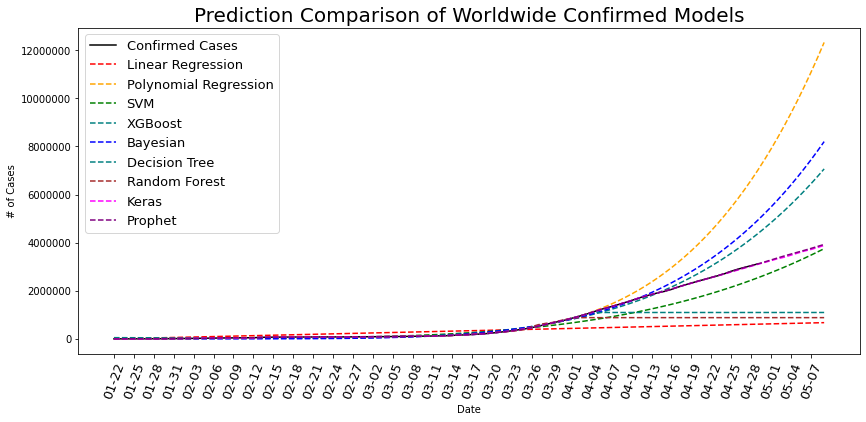

Runtime: 0.4766829013824463


In [73]:
t97=time.time()
plt.figure(figsize=(14, 6))
plt.plot(adjusted_dates, world_confirmed, color='black')
plt.plot(future_range_dates_short, linear_world_conf_pred, linestyle='dashed', color='red')
plt.plot(future_range_dates_short, poly_world_conf_pred, linestyle='dashed', color='orange')
plt.plot(future_range_dates_short, svm_world_conf_pred, linestyle='dashed', color='green')
plt.plot(future_range_dates_short, xgb_world_conf_pred, linestyle='dashed', color='teal')
plt.plot(future_range_dates_short, bayesian_world_conf_pred, linestyle='dashed', color='blue')
plt.plot(future_range_dates_short, decisionTree_world_conf_pred, linestyle='dashed', color='teal')
plt.plot(future_range_dates_short, randomForest_world_conf_pred, linestyle='dashed', color='brown')
plt.plot(future_range_dates_short,keras_pred_conf[:-1], linestyle='dashed', color='magenta')
plt.plot(future_range_dates_short, proph_w_conf, linestyle='dashed', color='purple')
plt.title('Prediction Comparison of Worldwide Confirmed Models', size=20)
plt.xlabel('Date', size=10)
plt.ylabel('# of Cases', size=10)
plt.legend(['Confirmed Cases', 'Linear Regression', 'Polynomial Regression', 'SVM', 'XGBoost', 'Bayesian', 'Decision Tree', 'Random Forest', 'Keras', 'Prophet'], prop={'size': 13})
plt.xticks(np.arange(len(future_range_dates), step=3),size=13, rotation=70)
plt.yticks(size=10)
ax = plt.gca()
ax.yaxis.get_major_formatter().set_scientific(False)
plt.show()
t98=time.time()
print('Runtime:', t98-t97)

## Combined Evaluation Metrics
#### Results from models throughout this notebook can be seen below:

In [74]:
t99=time.time()
table = [["Mean Absolute Err",mAE_linear_world_conf, mAE_poly_world_conf, mAE_svm_world_conf, mAE_xgb_world_conf,mAE_bayesian_world_conf,mAE_ranFor_world_conf,mAE_keras_world_conf,mAE_proph_world_conf,mAE_sir_world_conf],
         ["Mean Squared Err",mSE_linear_world_conf,mSE_poly_world_conf,mSE_svm_world_conf,mSE_xgb_world_conf,mSE_bayesian_world_conf,mSE_ranFor_world_conf,mSE_keras_world_conf,mSE_proph_world_conf,mSE_sir_world_conf],
         ["Mean Squared Log Err",mSLE_linear_world_conf,mSLE_poly_world_conf,mSLE_svm_world_conf,mSLE_xgb_world_conf,mSLE_bayesian_world_conf,mSLE_ranFor_world_conf,mSLE_keras_world_conf,mSLE_sir_world_conf],
         ["Root Mean Squared Err",rMSE_linear_world_conf,rMSE_poly_world_conf,rMSE_svm_world_conf,rMSE_xgb_world_conf,rMSE_bayesian_world_conf,rMSE_ranFor_world_conf,rMSE_keras_world_conf,rMSE_proph_world_conf,rMSE_sir_world_conf],
         ["Median Absolute Err",mAbE_linear_world_conf,mAbE_poly_world_conf,mAbE_svm_world_conf,mAbE_xgb_world_conf,mAbE_bayesian_world_conf,mAbE_ranFor_world_conf,mAbE_keras_world_conf,mAbE_proph_world_conf,mAbE_sir_world_conf],
         ["Mean Absolute Percentage Err",mAPE_linear_world_conf,mAPE_poly_world_conf,mAPE_svm_world_conf,mAPE_xgb_world_conf,mAPE_bayesian_world_conf,mAPE_ranFor_world_conf,mAPE_keras_world_conf,mAPE_proph_world_conf,mAPE_sir_world_conf],
         ["R2 Score",r2_linear_world_conf,r2_poly_world_conf,r2_svm_world_conf,r2_xgb_world_conf,r2_bayesian_world_conf,r2_ranFor_world_conf,r2_keras_world_conf,r2_proph_world_conf,r2_sir_world_conf],
         ["Mean Poisson Deviance",mPD_linear_world_conf,mPD_poly_world_conf,mPD_svm_world_conf,mPD_xgb_world_conf,mPD_bayesian_world_conf,mPD_ranFor_world_conf,mPD_keras_world_conf,mPD_sir_world_conf],
         ["Mean Gamma Deviance",mGD_linear_world_conf,mGD_poly_world_conf,mGD_svm_world_conf,mGD_xgb_world_conf,mGD_bayesian_world_conf,mGD_ranFor_world_conf,mGD_keras_world_conf,mGD_sir_world_conf],
         ["Mean Tweedie Deviance",mTD_linear_world_conf,mTD_poly_world_conf,mTD_svm_world_conf,mTD_xgb_world_conf,mTD_bayesian_world_conf,mTD_ranFor_world_conf,mTD_keras_world_conf,mTD_proph_world_conf,mTD_sir_world_conf],
         ["Max Error",mE_linear_world_conf,mE_poly_world_conf,mE_svm_world_conf,mE_xgb_world_conf,mE_bayesian_world_conf,mE_ranFor_world_conf,mE_keras_world_conf,mE_proph_world_conf,mE_sir_world_conf],
         ["Explained Variance Score",mEVS_linear_world_conf,mEVS_poly_world_conf,mEVS_svm_world_conf,mEVS_xgb_world_conf,mEVS_bayesian_world_conf,mEVS_ranFor_world_conf,mEVS_keras_world_conf,mEVS_proph_world_conf,mEVS_sir_world_conf]]
headName = ['Evaluation Metric', 'Linear', 'Polynomial', 'SVM', 'XGBoost', 'Bayesian', 'Random Forest', 'Keras', 'Prophet', 'SIR']
display(HTML(tabulate.tabulate(table, tablefmt='html', headers=headName)))
t100=time.time()
print('Runtime:', t100-t99)

Evaluation Metric,Linear,Polynomial,SVM,XGBoost,Bayesian,Random Forest,Keras,Prophet,SIR
Mean Absolute Err,1.62167e+06,1.36139e+06,587274,358908,543574,1.2751e+06,8683.96,3541.6,1.4738e+11
Mean Squared Err,2.91534e+12,3.21752e+12,3.52854e+11,2.605e+11,6.02021e+11,1.96192e+12,1.06024e+08,2.28285e+07,2.12864e+24
Mean Squared Log Err,1.88744,0.216491,0.115526,0.0256676,0.0522695,0.813407,0.015022,21.2105,
Root Mean Squared Err,1.70744e+06,1.79374e+06,594015,510392,775900,1.40069e+06,10296.8,4777.92,1.45899e+12
Median Absolute Err,1.61792e+06,1.02899e+06,611365,132710,326164,1.27135e+06,8409.31,2744.38,58102.7
Mean Absolute Percentage Err,73.7902,53.2412,28.3062,14.1664,20.6601,55.7287,10.3988,23.7306,7.47907e+06
R2 Score,-7.67552,-8.57475,-0.0500302,0.224797,-0.791507,-4.83833,-0.207545,0.999974,-5.42255e+12
Mean Poisson Deviance,2.8468e+06,728165,205045,76700.3,164706,1.46822e+06,1287.06,2.94762e+11,
Mean Gamma Deviance,3.21926,0.178369,0.130487,0.0238311,0.0467806,1.18151,0.0156988,198.167,
Mean Tweedie Deviance,2.91534e+12,3.21752e+12,3.52854e+11,2.605e+11,6.02021e+11,1.96192e+12,1.06024e+08,2.28285e+07,2.12864e+24


Runtime: 0.00974583625793457


#### The table above serves to compare the evaluation metrics of each model against different regions and sizes of data. As the same models are applied to different sizes of data sets, the evaluation metrics are compared and show which models have more acceptable errors for those particular data set sizes based on region selected.